In [1]:
# =========================================
# 0) CONFIG (여기만 바꿔 끼우면 됩니다)
# =========================================
CONFIG = {
    # 데이터
    "csv_path": "data/semiconductor_quality_control.csv",

    # 타깃 후보 (우선순위대로 탐색)
    "target_candidates": ["Defect"],
    
    # 공정(설비) 분리 기준 컬럼
    "tool_type_candidates": ["Tool_Type", "tool_type"],

    # Join_Status를 타깃으로 쓰고 싶다면 True로 (Defect와 중복/누수 확인 로직 포함)
    "use_join_status_as_target": False,
    "join_status_col_candidates": ["Join_Status"],
    "join_status_positive_values": ["Non-Joining", "FAIL", "Fail", "NG", "Bad", "Defect", "1"],  # 필요시 수정

    # 누수 위험 컬럼/ID류/시간류 (피처에서 제거)
    "drop_cols_always": ["Process_ID", "Timestamp"],

    # Etch_Depth 후보 (A/B 시나리오 분기)
    "etch_depth_candidates": ["Etch_Depth"],

    # 공정(설비) 분리 기준 컬럼
    "tool_type_candidates": ["Tool_Type", "tool_type"],

    # 그룹 분할 우선순위: wafer/lot 단위
    "group_candidates": ["Wafer_ID", "wafer_id", "Lot_ID", "lot_id", "die_id", "Die_ID"],

    # 시간 분할 컬럼 후보 (분할에만 사용)
    "time_candidates": ["Timestamp", "timestamp", "DateTime", "datetime", "time", "Time"],

    # 모델/검증
    "random_state": 42,
    "test_size": 0.2,
    "cv_splits": 5,
    "n_iter_search": 30,
    "scoring_primary": "average_precision",  # PR-AUC(AP)
    "precision_constraint": 0.90,            # threshold 선택 시 precision 최소
    "calibration": None,                     # None / "sigmoid" / "isotonic"

    # 전처리 옵션
    "use_iterative_imputer": False,          # True로 바꾸면 IterativeImputer 사용
    "winsorize_limits": (0.01, 0.01),        # 상하 1% winsorization
    "use_isolation_forest": False,           # 선택 옵션(훈련셋 필터링 원칙)

    # 출력/저장
    "model_output_dir": "./artifacts",
    "model_name_prefix": "semi_defect_model",
}



In [2]:
# =========================================
# 1) Imports (preprocess & modeling)
# =========================================
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import List, Optional

from sklearn.model_selection import StratifiedKFold, GroupKFold, TimeSeriesSplit, RandomizedSearchCV, train_test_split
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, roc_auc_score,
    f1_score, precision_score, recall_score, confusion_matrix,
    ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.base import BaseEstimator, TransformerMixin



In [3]:
# =========================================
# 2) Load data & basic checks
# =========================================

df = pd.read_csv(CONFIG["csv_path"])
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

target_col = "Defect"
tool_col = "Tool_Type"


print("Target col:", target_col)
print("Tool_Type col:", tool_col)

# 결측률 상위 확인
print("Missing ratio (top 10):")
print(df.isna().mean().sort_values(ascending=False).head(16))


Shape: (4219, 16)
Columns: ['Process_ID', 'Timestamp', 'Tool_Type', 'Wafer_ID', 'Chamber_Temperature', 'Gas_Flow_Rate', 'RF_Power', 'Etch_Depth', 'Rotation_Speed', 'Vacuum_Pressure', 'Stage_Alignment_Error', 'Vibration_Level', 'UV_Exposure_Intensity', 'Particle_Count', 'Defect', 'Join_Status']
Target col: Defect
Tool_Type col: Tool_Type
Missing ratio (top 10):
Process_ID               0.0
Timestamp                0.0
Tool_Type                0.0
Wafer_ID                 0.0
Chamber_Temperature      0.0
Gas_Flow_Rate            0.0
RF_Power                 0.0
Etch_Depth               0.0
Rotation_Speed           0.0
Vacuum_Pressure          0.0
Stage_Alignment_Error    0.0
Vibration_Level          0.0
UV_Exposure_Intensity    0.0
Particle_Count           0.0
Defect                   0.0
Join_Status              0.0
dtype: float64


In [4]:
# =========================================
# 3.5) ID/시간 컬럼 제거 (원본 분리 전에)
# =========================================

cols_to_drop = [c for c in ["Process_ID", "Timestamp","Join_Status"] if c in df.columns]
if cols_to_drop:
    df = df.drop(columns=cols_to_drop)
    print("Dropped columns:", cols_to_drop)
else:
    print("No Process_ID/Timestamp/Join_Status columns found.")


Dropped columns: ['Process_ID', 'Timestamp', 'Join_Status']


In [5]:
# =========================================
# 4) Tool_Type별 원본 데이터 분리 
# =========================================

tool_raw = {}
for t in df[tool_col].unique():
    df_t = df[df[tool_col] == t].copy()
    tool_raw[t] = df_t
    print(f"{t}: shape={df_t.shape}")

from IPython.display import display

display(tool_raw["Etching"].head())
display(tool_raw["Deposition"].head())
display(tool_raw["Lithography"].head())


Lithography: shape=(1385, 13)
Deposition: shape=(1416, 13)
Etching: shape=(1418, 13)


Tool_Type  Wafer_ID  Chamber_Temperature  Gas_Flow_Rate    RF_Power  \
3    Etching  WAF46726            79.467364      47.569284  301.464082   
6    Etching  WAF93190            74.031582      34.524690  325.060209   
8    Etching  WAF90138            75.574564      31.129065  222.565983   
9    Etching  WAF34798            89.370413      74.383993  221.146587   
12   Etching  WAF54023            69.662915      50.122469  271.631064   

    Etch_Depth  Rotation_Speed  Vacuum_Pressure  Stage_Alignment_Error  \
3   488.986118     1342.928970         0.492940               1.564590   
6   502.503207     1860.943159         0.557813               1.858771   
8   485.660598     1037.924539         0.494761               2.842610   
9   618.681459     1342.417979         0.446146               1.823190   
12  403.201004     1383.952796         0.438330               1.827425   

    Vibration_Level  UV_Exposure_Intensity  Particle_Count  Defect  
3          0.009416             133.259454             178       0  
6          0.008604             115.391153             445       1  
8          0.015432             123.818165             970       0  
9          0.015130             154.059938             787       0  
12         0.003506             122.514252             109       0

Tool_Type  Wafer_ID  Chamber_Temperature  Gas_Flow_Rate    RF_Power  \
1   Deposition  WAF31094            74.341499      39.350802  364.527083   
2   Deposition  WAF44062            74.626094      38.181393  314.257182   
7   Deposition  WAF48082            74.972943      34.676196  219.520268   
23  Deposition  WAF66820            69.510619      57.636426  315.717919   
24  Deposition  WAF90800            76.939137      44.227121  355.982551   

    Etch_Depth  Rotation_Speed  Vacuum_Pressure  Stage_Alignment_Error  \
1   493.382895     1433.488274         0.407351               2.970405   
2   589.544476     1311.345430         0.480282               1.310555   
7   564.177109     1250.188972         0.570861               0.037162   
23  611.399196     1152.332112         0.514648               2.254649   
24  505.679897     1359.628708         0.477417               2.752692   

    Vibration_Level  UV_Exposure_Intensity  Particle_Count  Defect  
1          0.007927             109.449848             525       0  
2          0.008856             161.172686             729       0  
7          0.009037             136.742235             653       0  
23         0.001079              95.330599             112       0  
24         0.019110             116.621626             605       0

Tool_Type  Wafer_ID  Chamber_Temperature  Gas_Flow_Rate    RF_Power  \
0   Lithography  WAF58120            74.077728      56.527432  324.281923   
4   Lithography  WAF39030            76.221205      59.152873  289.702098   
5   Lithography  WAF77484            72.406000      52.230743  286.161543   
10  Lithography  WAF89845            74.777007      46.819801  279.926539   
11  Lithography  WAF49453            85.666323      69.293533  285.921599   

    Etch_Depth  Rotation_Speed  Vacuum_Pressure  Stage_Alignment_Error  \
0   554.358076     1397.936121         0.549974               2.147302   
4   458.012763     1785.025252         0.557101               2.338089   
5   495.476249     1363.693532         0.432724               3.133414   
10  563.066838     2071.380657         0.392305               0.197213   
11  511.264062     1360.282764         0.529752               2.423294   

    Vibration_Level  UV_Exposure_Intensity  Particle_Count  Defect  
0          0.009007             128.419361             118       0  
4          0.009590             117.129348             514       1  
5          0.009360             139.292220             513       0  
10         0.011887             108.978847             298       0  
11         0.018540             118.536442             796       0

=== Lithography ===


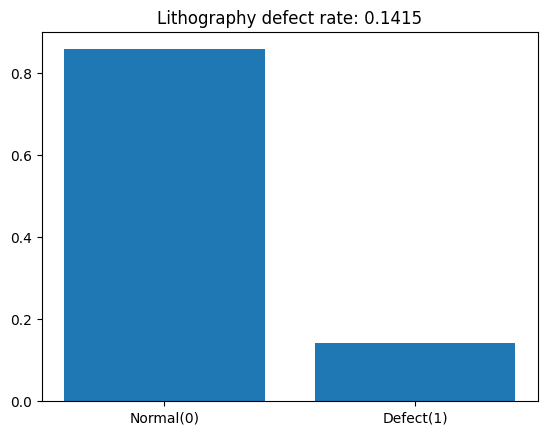

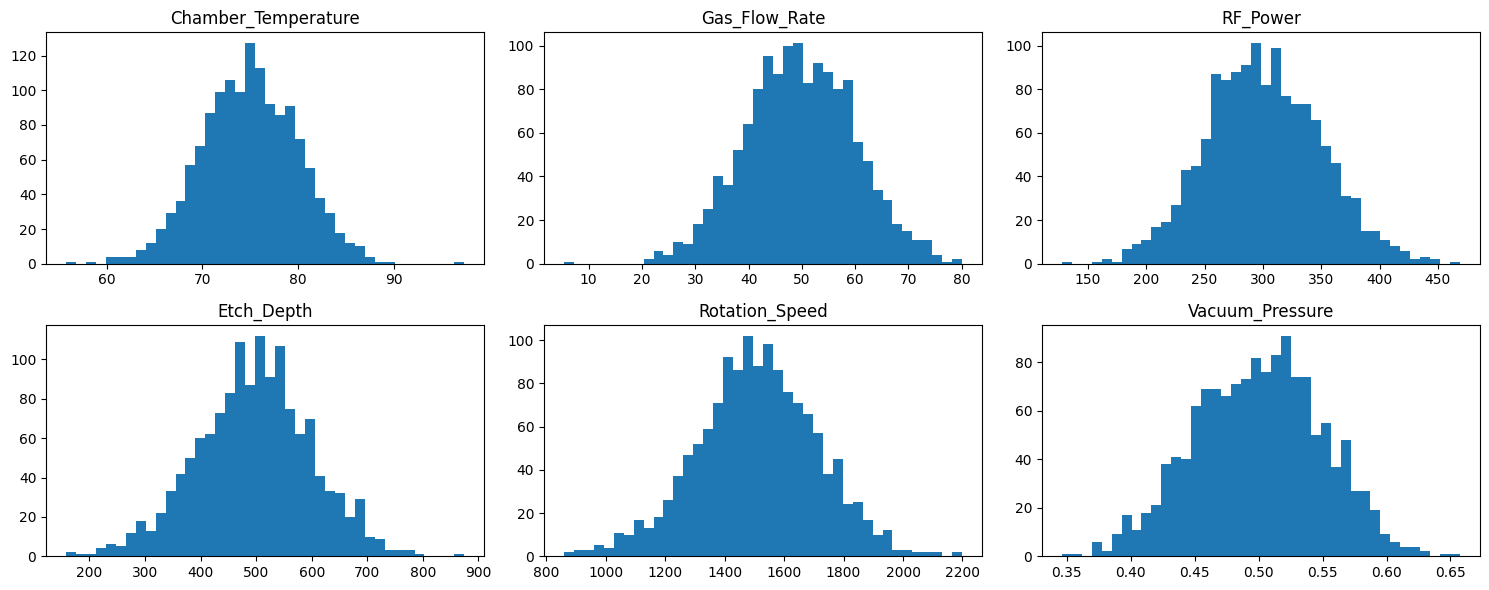

=== Deposition ===


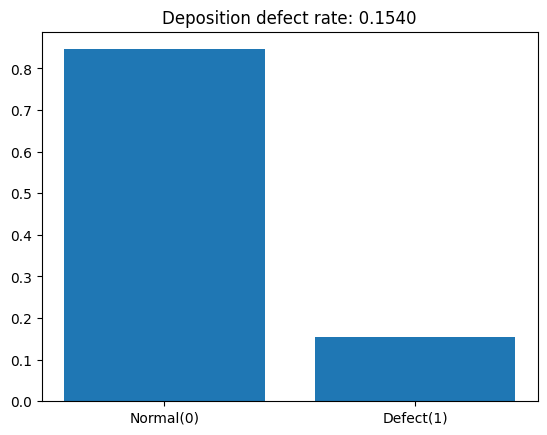

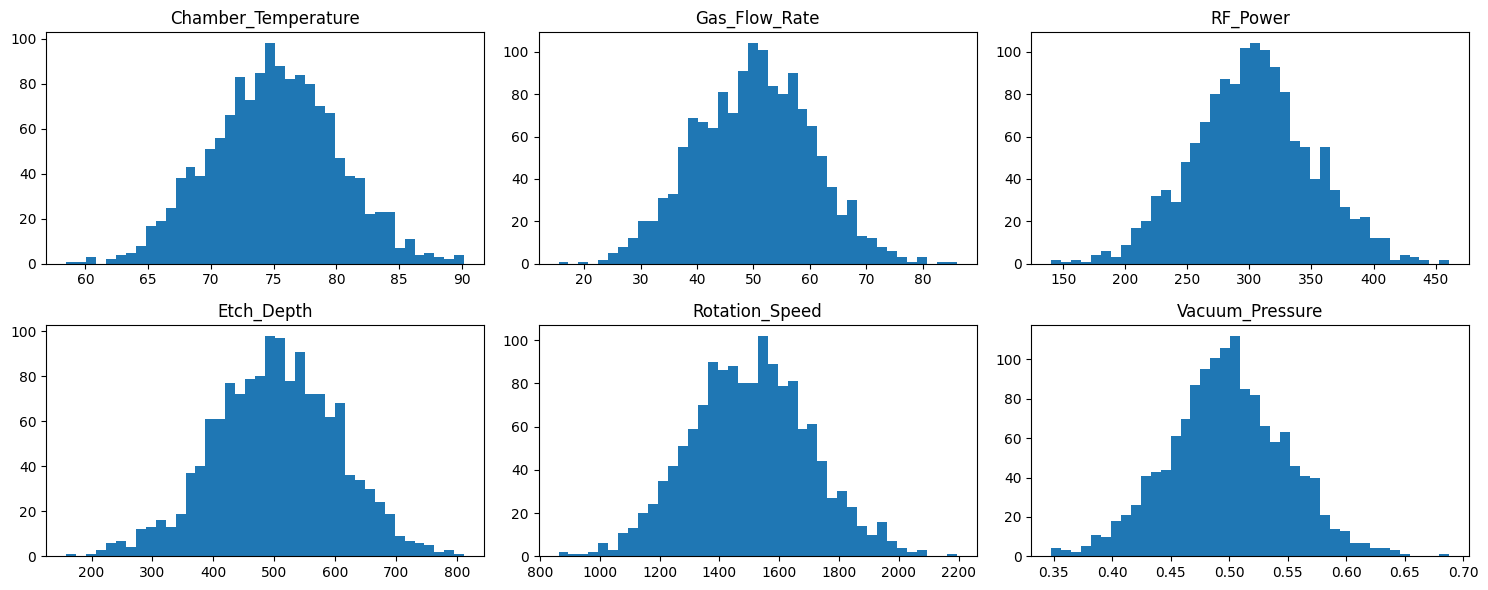

=== Etching ===


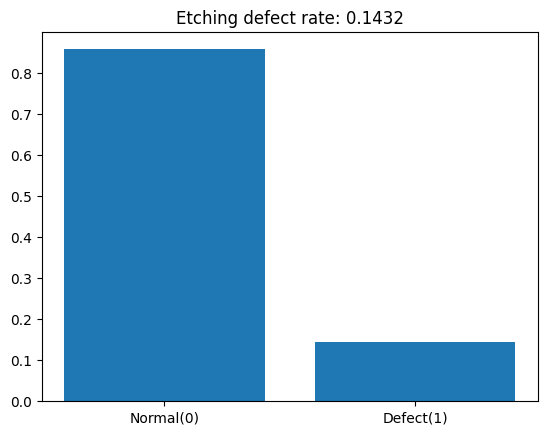

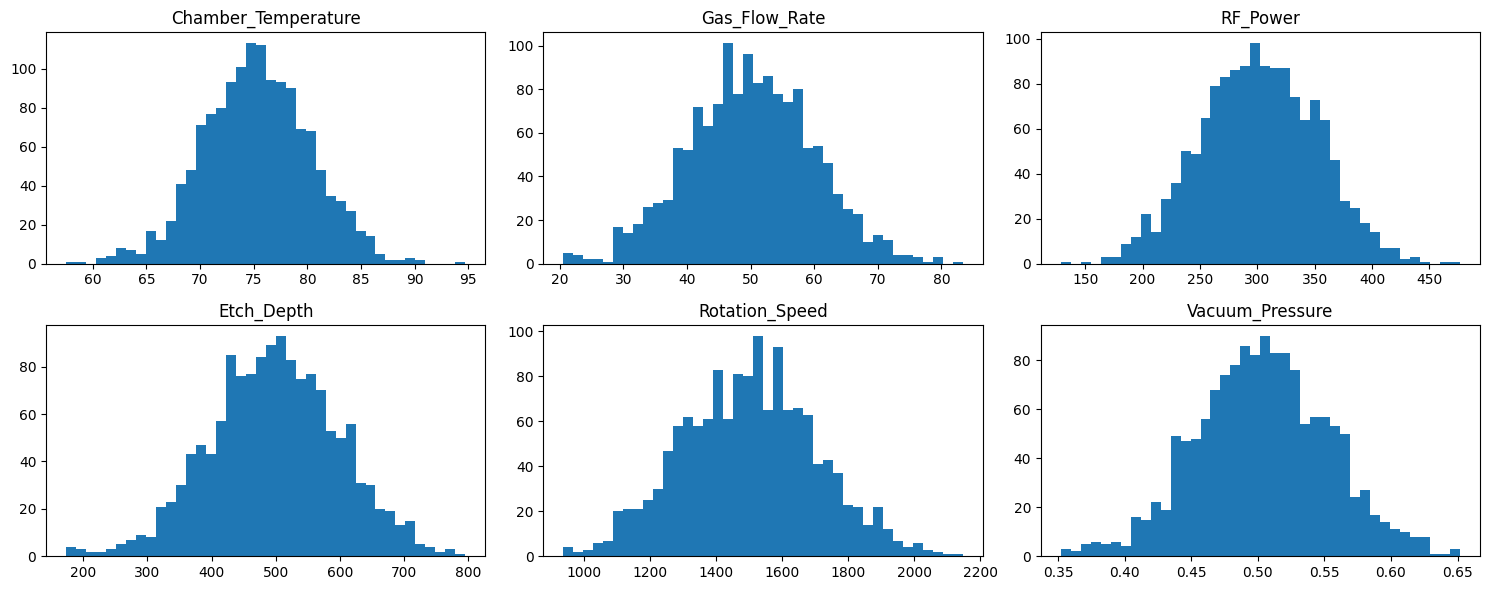

In [6]:
# =========================================
# 5) 공정별 시각화 (기본)
# =========================================

def plot_tool_basic(df_t, tool_name, target_col="Defect"):
    # 결함 비율
    rate = df_t[target_col].mean()
    plt.figure()
    plt.bar(["Normal(0)", "Defect(1)"], [1-rate, rate])
    plt.title(f"{tool_name} defect rate: {rate:.4f}")
    plt.show()

    # 주요 수치형 컬럼 분포
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c]) and c != target_col]
    cols = num_cols[:6]  # 너무 많으면 상위 6개만
    if not cols:
        print(f"{tool_name}: numeric columns 없음")
        return

    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))
    plt.figure(figsize=(5*ncols, 3*nrows))
    for i, c in enumerate(cols, 1):
        plt.subplot(nrows, ncols, i)
        plt.hist(df_t[c], bins=40)
        plt.title(c)
    plt.tight_layout()
    plt.show()


for tool_name, df_t in tool_raw.items():
    print(f"=== {tool_name} ===")
    plot_tool_basic(df_t, tool_name, target_col=target_col)



=== Lithography correlation ===


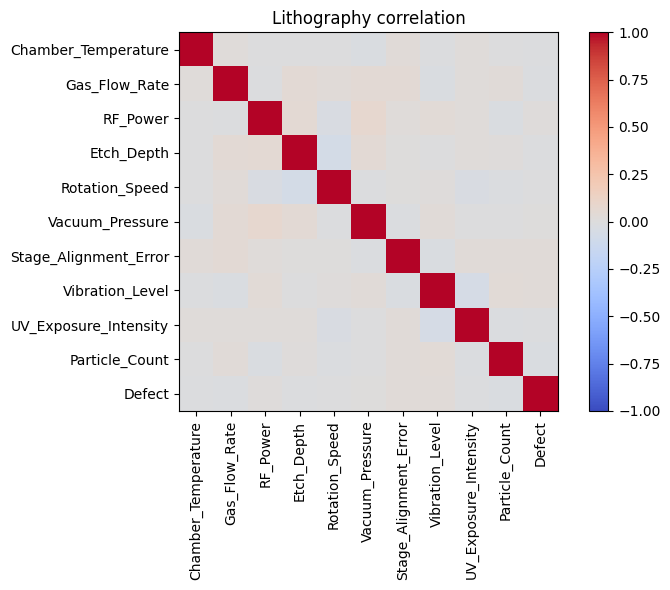

=== Deposition correlation ===


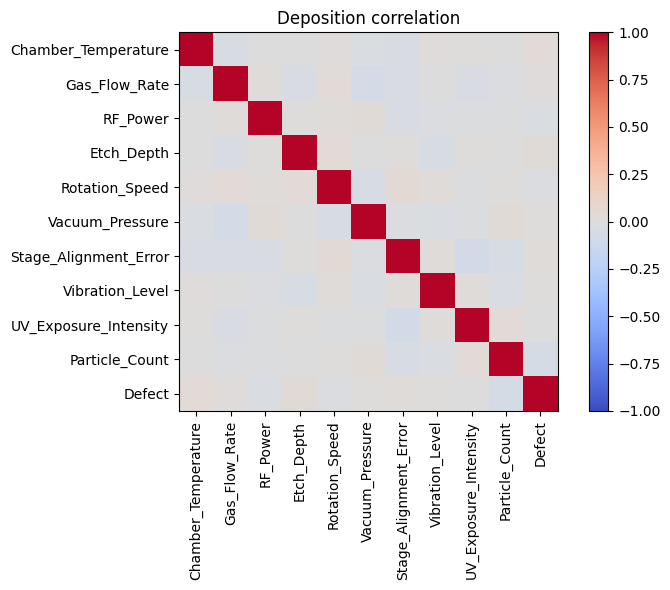

=== Etching correlation ===


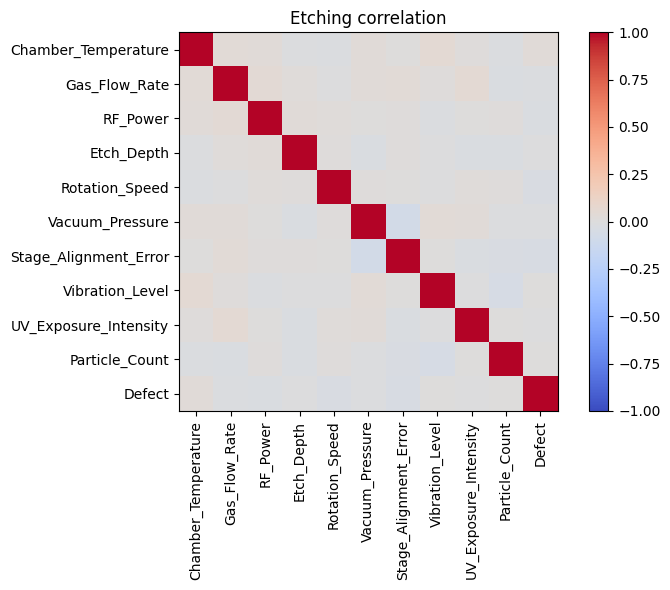

Etching top corr pairs:


feat_a                 feat_b      corr  abs_corr
0        Vacuum_Pressure  Stage_Alignment_Error -0.075057  0.075057
1        Vibration_Level         Particle_Count -0.050817  0.050817
2          Gas_Flow_Rate  UV_Exposure_Intensity  0.047964  0.047964
3    Chamber_Temperature        Vibration_Level  0.046951  0.046951
4  Stage_Alignment_Error                 Defect -0.043209  0.043209
5          Gas_Flow_Rate               RF_Power  0.041535  0.041535
6  Stage_Alignment_Error         Particle_Count -0.038607  0.038607
7          Gas_Flow_Rate  Stage_Alignment_Error  0.037385  0.037385
8    Chamber_Temperature          Gas_Flow_Rate  0.034546  0.034546
9         Rotation_Speed                 Defect -0.034353  0.034353

Deposition top corr pairs:


feat_a                 feat_b      corr  abs_corr
0  Stage_Alignment_Error  UV_Exposure_Intensity -0.073399  0.073399
1          Gas_Flow_Rate        Vacuum_Pressure -0.062702  0.062702
2         Particle_Count                 Defect -0.055586  0.055586
3  Stage_Alignment_Error         Particle_Count -0.049316  0.049316
4         Rotation_Speed        Vacuum_Pressure -0.048994  0.048994
5             Etch_Depth        Vibration_Level -0.041025  0.041025
6         Rotation_Speed  Stage_Alignment_Error  0.039265  0.039265
7    Chamber_Temperature          Gas_Flow_Rate -0.039195  0.039195
8          Gas_Flow_Rate         Rotation_Speed  0.036964  0.036964
9    Chamber_Temperature                 Defect  0.036854  0.036854

Lithography top corr pairs:


feat_a                 feat_b      corr  abs_corr
0         RF_Power        Vacuum_Pressure  0.071226  0.071226
1       Etch_Depth         Rotation_Speed -0.068848  0.068848
2  Vibration_Level  UV_Exposure_Intensity -0.059298  0.059298
3         RF_Power             Etch_Depth  0.049963  0.049963
4    Gas_Flow_Rate  Stage_Alignment_Error  0.045577  0.045577
5    Gas_Flow_Rate             Etch_Depth  0.044871  0.044871
6    Gas_Flow_Rate        Vacuum_Pressure  0.041127  0.041127
7       Etch_Depth        Vacuum_Pressure  0.040360  0.040360
8         RF_Power         Rotation_Speed -0.036217  0.036217
9         RF_Power        Vibration_Level  0.036124  0.036124

In [7]:
# =========================================
# 6) 공정별 상관관계 (숫자형)
# =========================================

def plot_corr(df_t, tool_name, target_col="Defect"):
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c])]
    if len(num_cols) < 2:
        print(f"{tool_name}: numeric columns 부족")
        return

    c = df_t[num_cols].corr()
    plt.figure(figsize=(8, 6))
    plt.imshow(c, cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title(f"{tool_name} correlation")
    plt.tight_layout()
    plt.show()


for tool_name, df_t in tool_raw.items():
    print(f"=== {tool_name} correlation ===")
    plot_corr(df_t, tool_name, target_col=target_col)


def plot_top_corr_pairs(df_t, tool_name, topk=10):
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c])]
    if len(num_cols) < 2: return
    c = df_t[num_cols].corr()
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            a, b = num_cols[i], num_cols[j]
            val = c.loc[a, b]
            if pd.isna(val): continue
            pairs.append((a, b, float(val), float(abs(val))))
    pairs = sorted(pairs, key=lambda x: x[3], reverse=True)[:topk]
    out = pd.DataFrame(pairs, columns=["feat_a", "feat_b", "corr", "abs_corr"])
    print(f"{tool_name} top corr pairs:")
    display(out)

for tool_name in ["Etching", "Deposition", "Lithography"]:
    plot_top_corr_pairs(tool_raw[tool_name], tool_name, topk=10)



[RUNNING ANALYSIS] Tool: Lithography


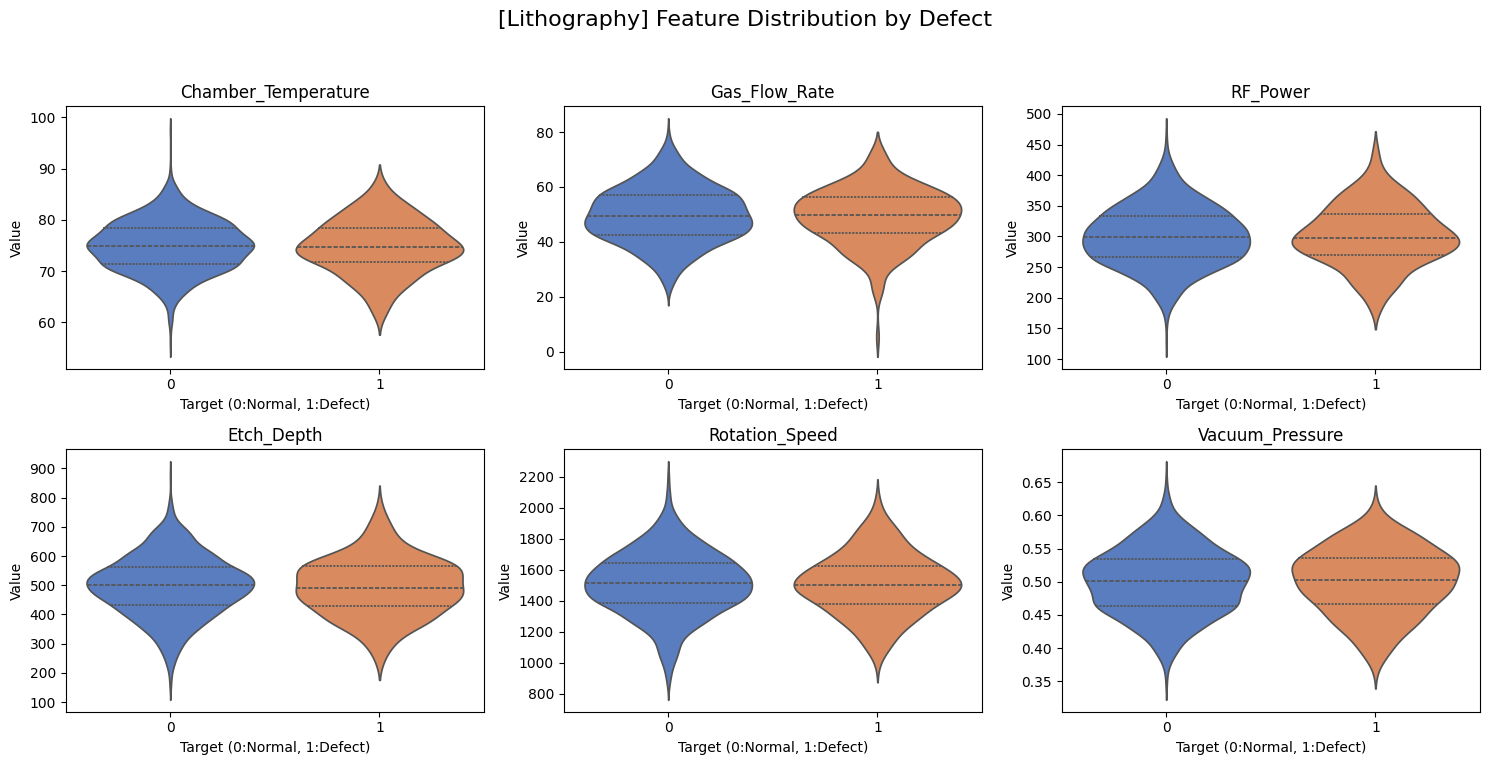

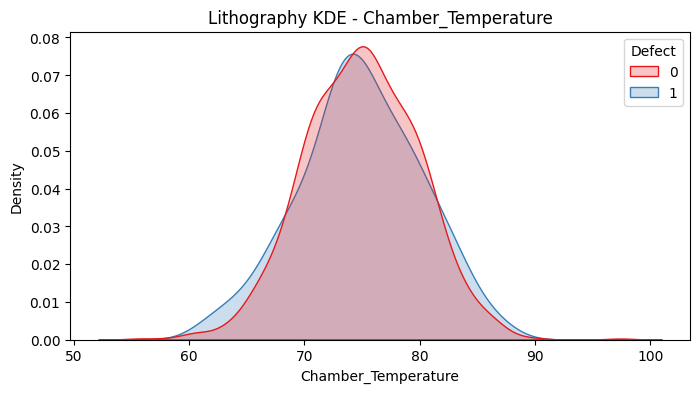

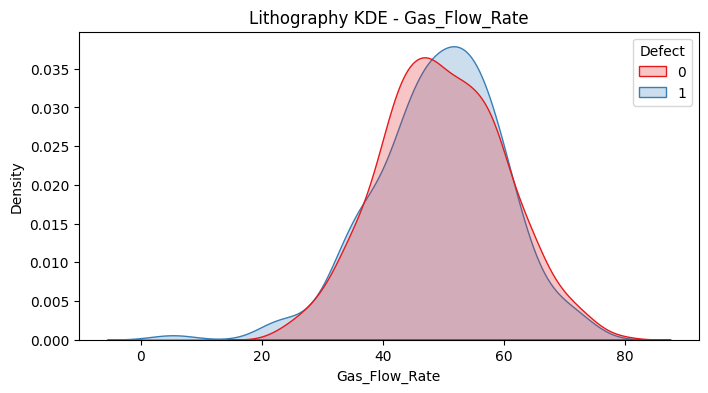

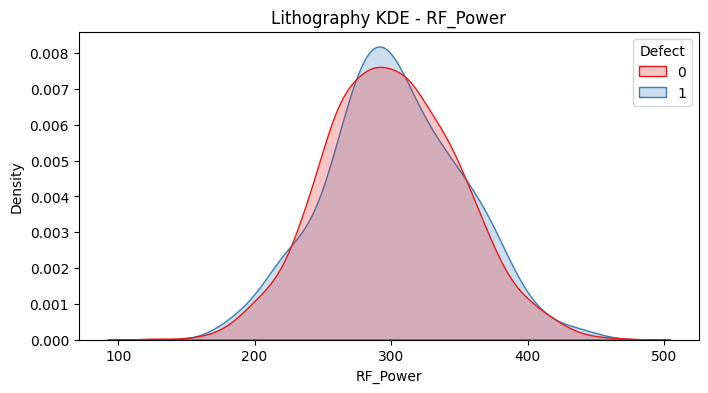

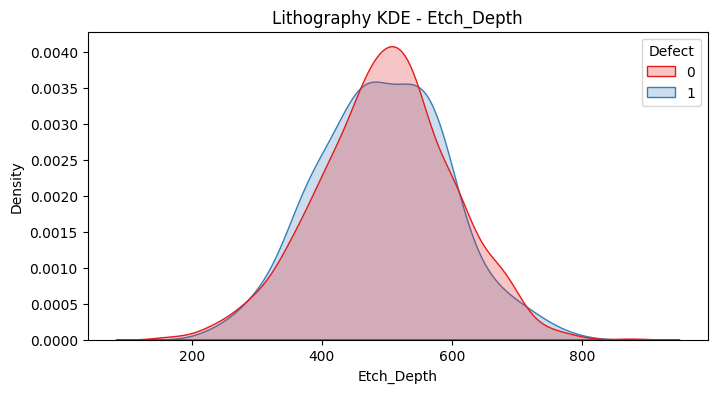

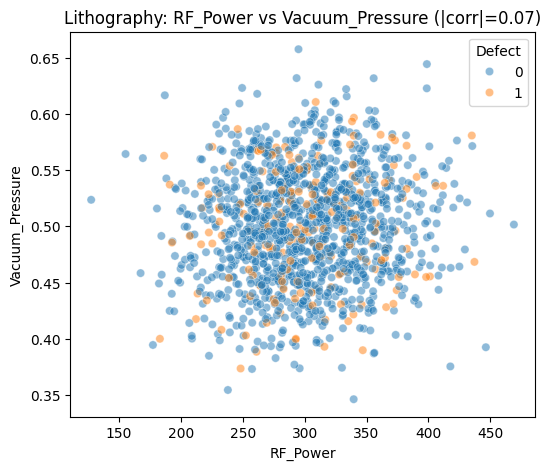

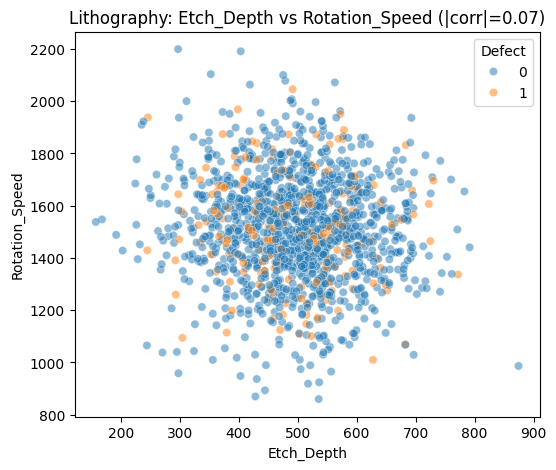

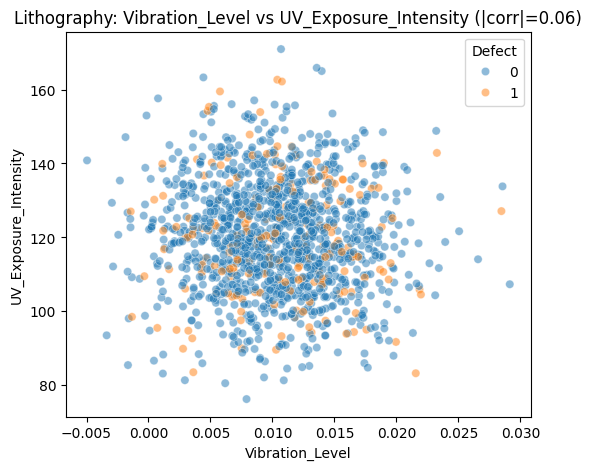

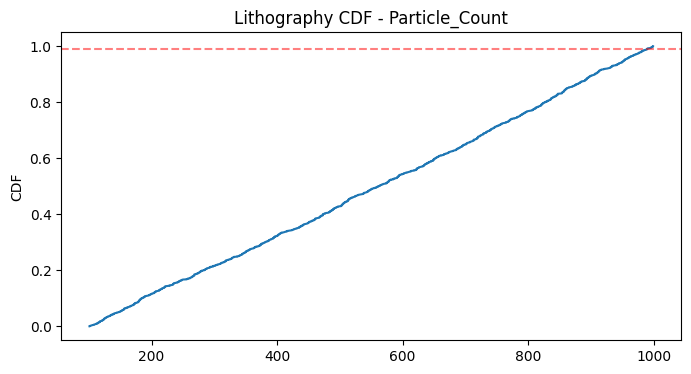

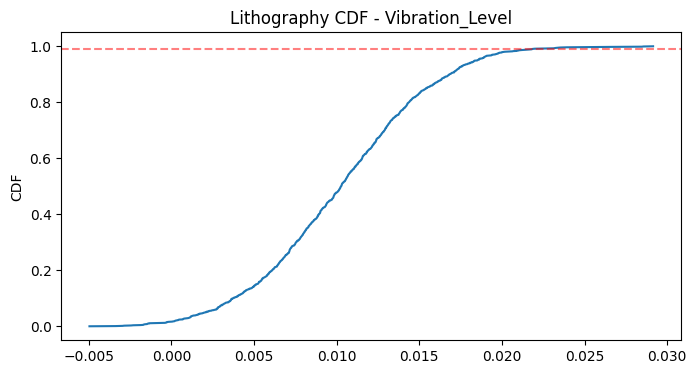

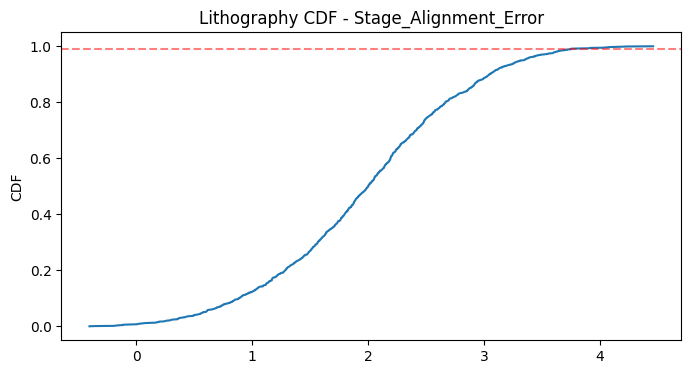


[RUNNING ANALYSIS] Tool: Deposition


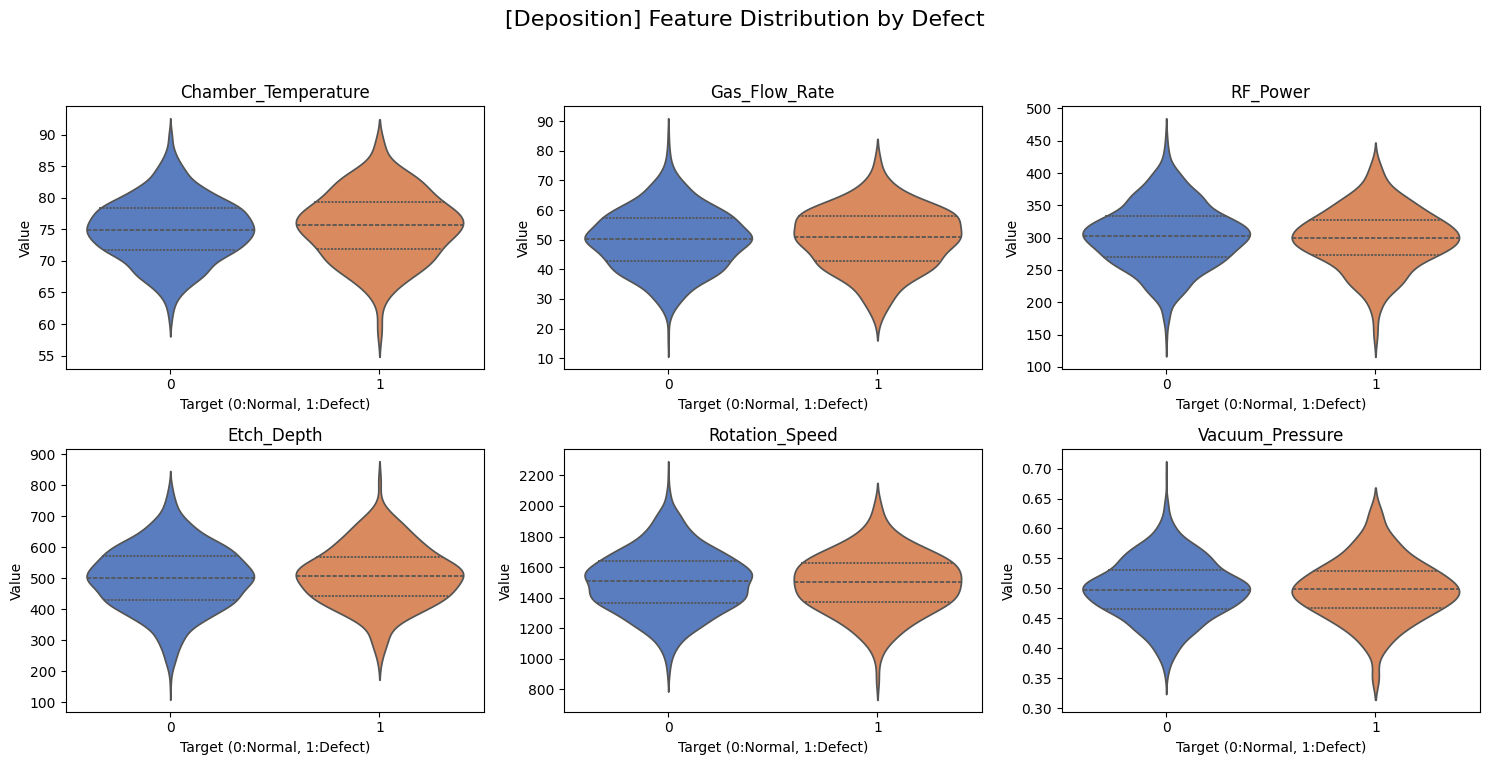

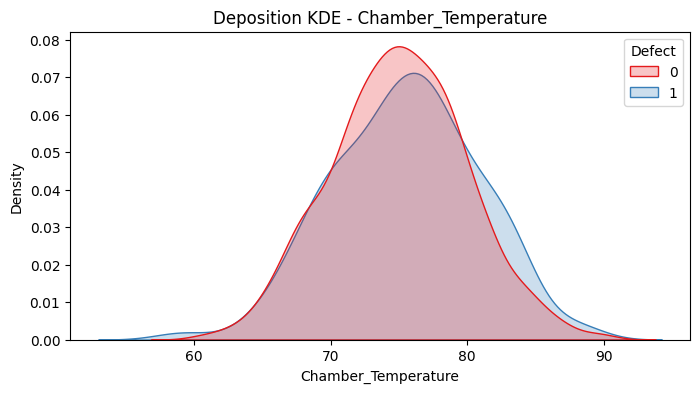

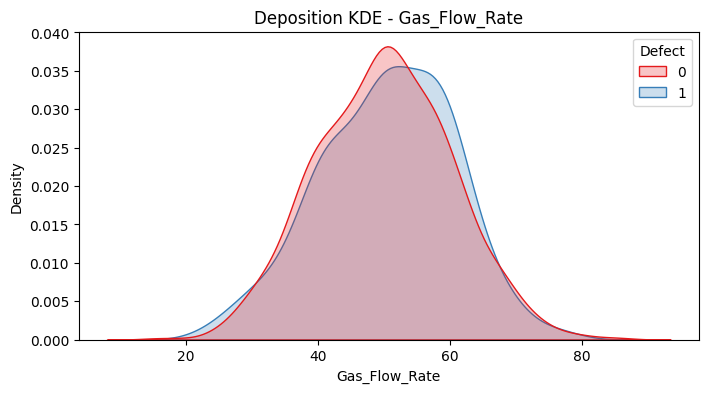

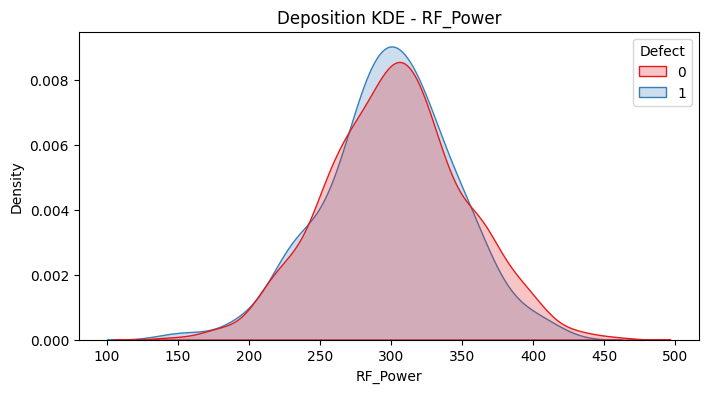

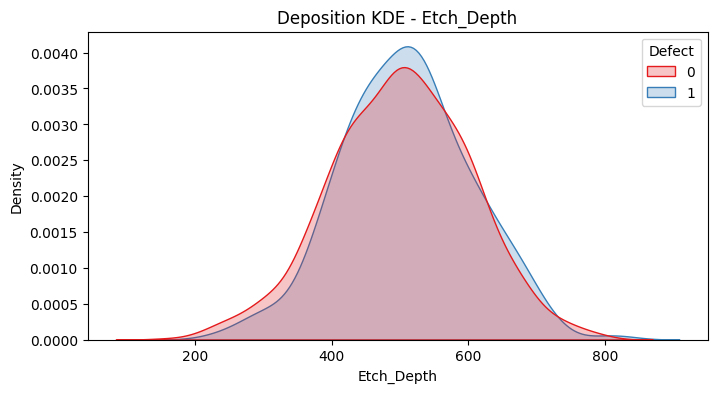

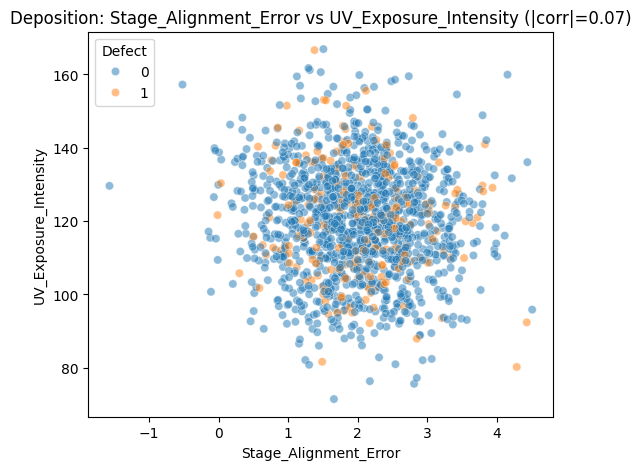

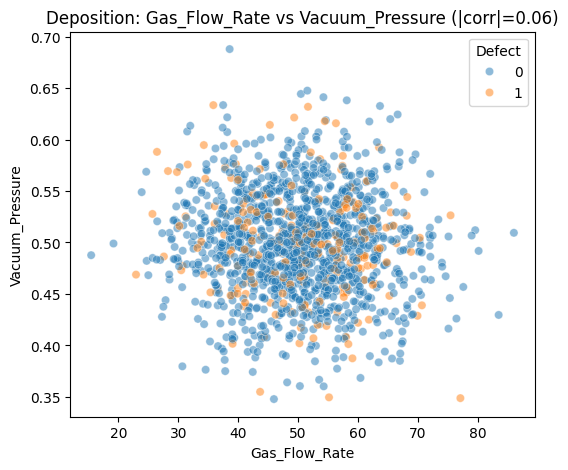

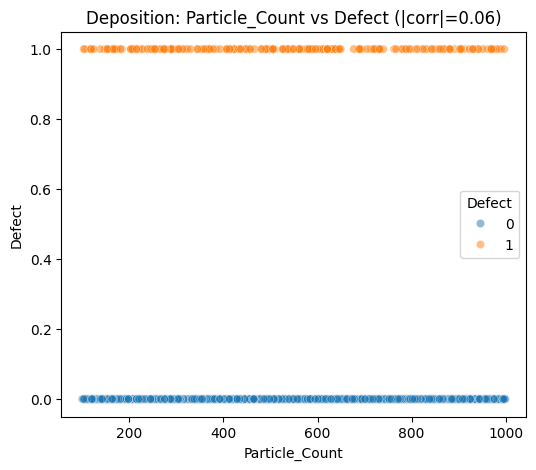

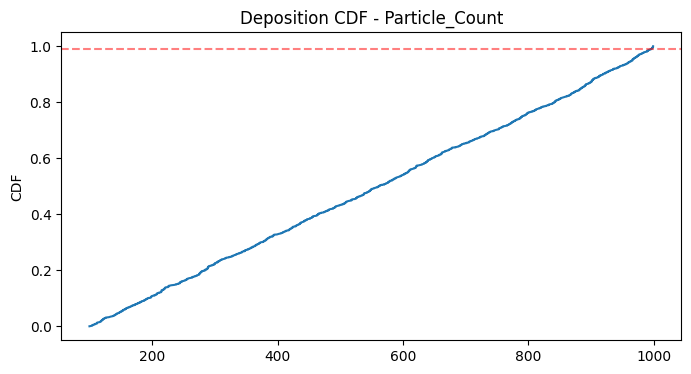

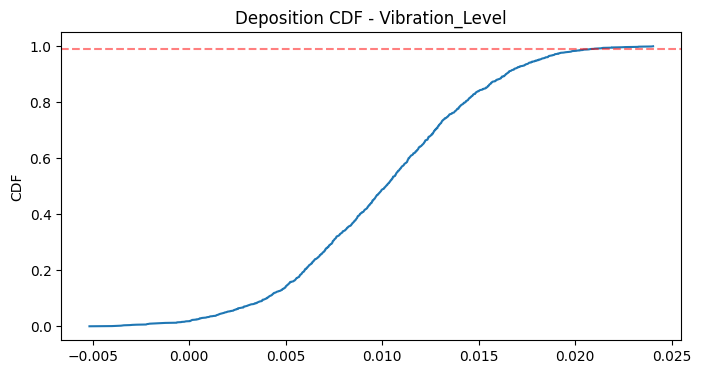

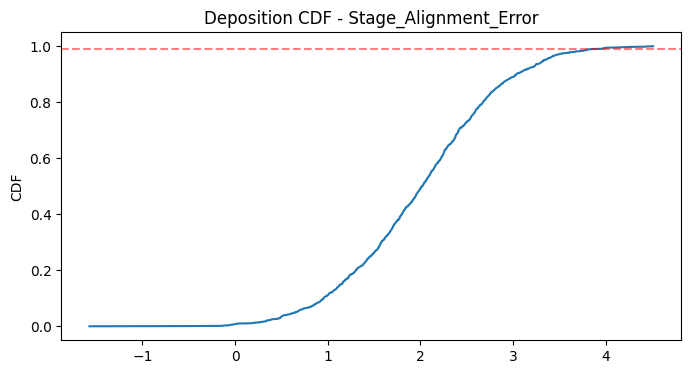


[RUNNING ANALYSIS] Tool: Etching


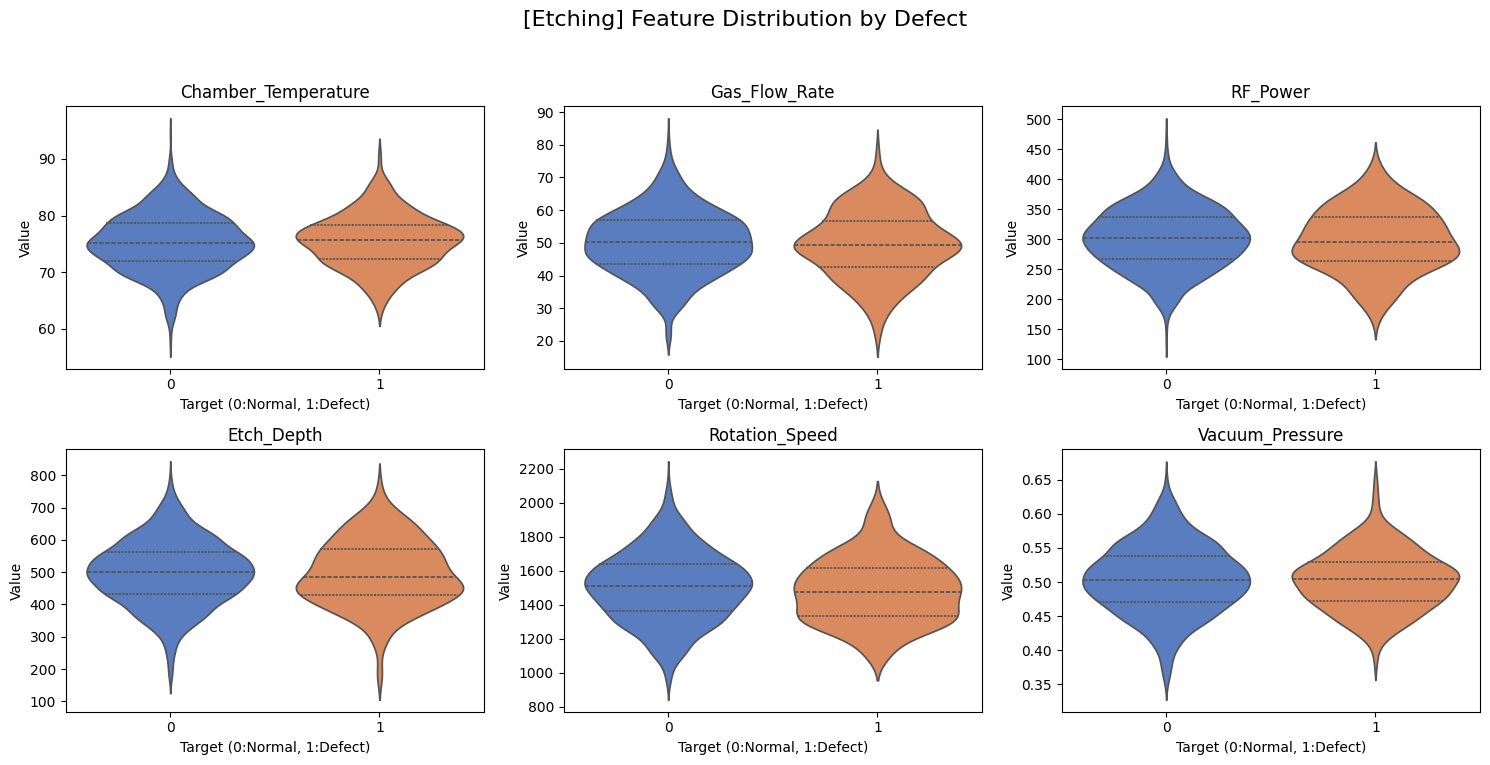

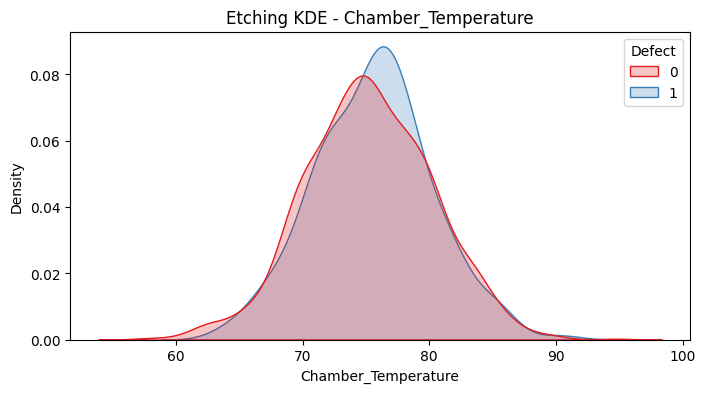

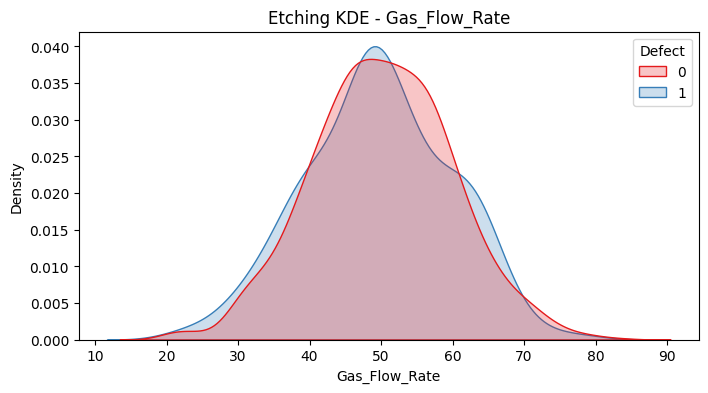

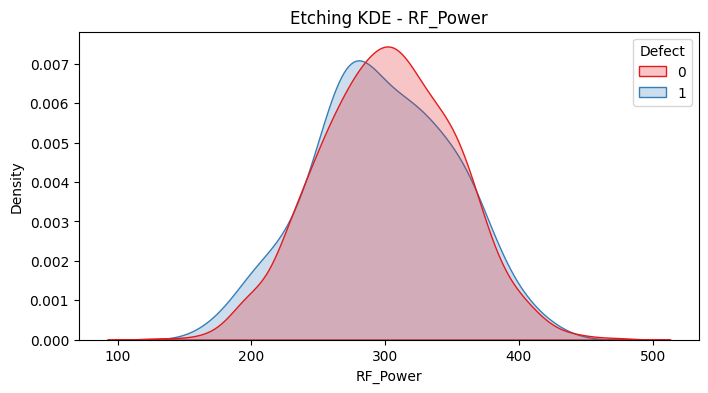

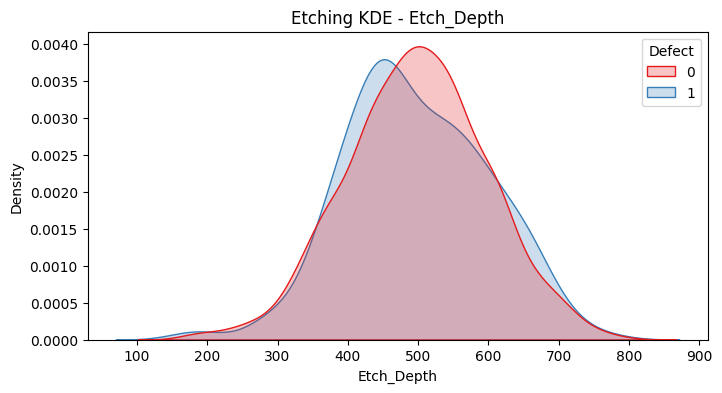

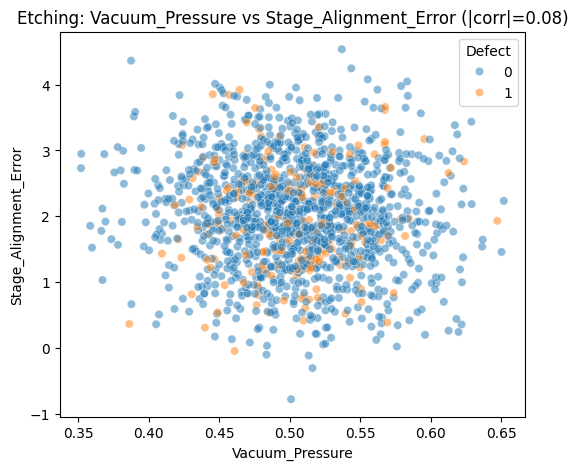

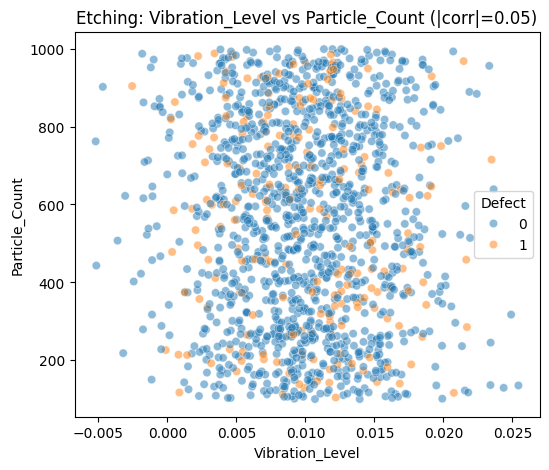

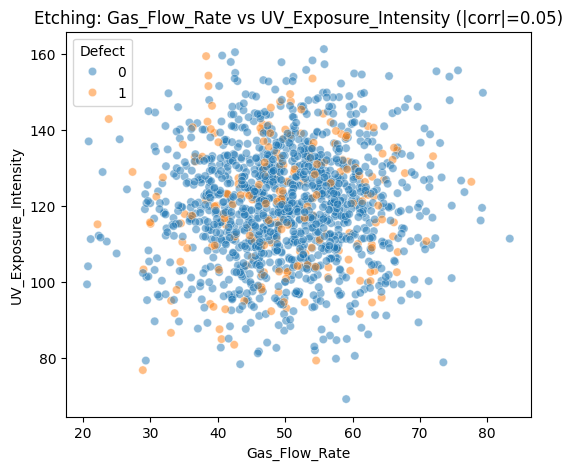

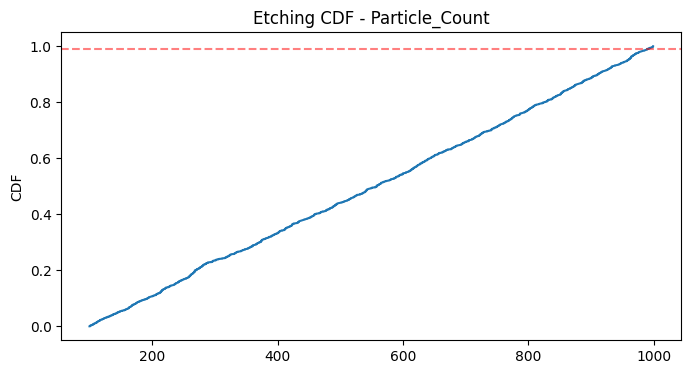

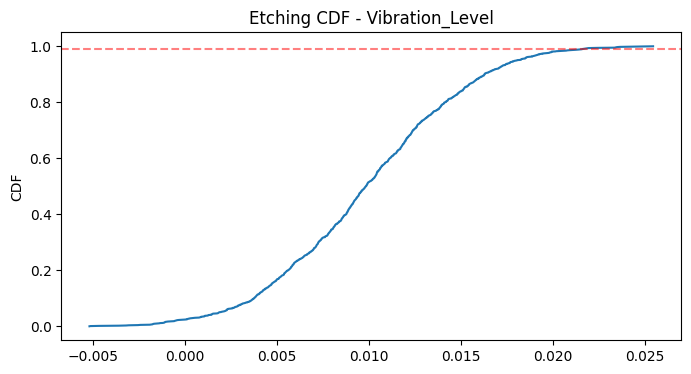

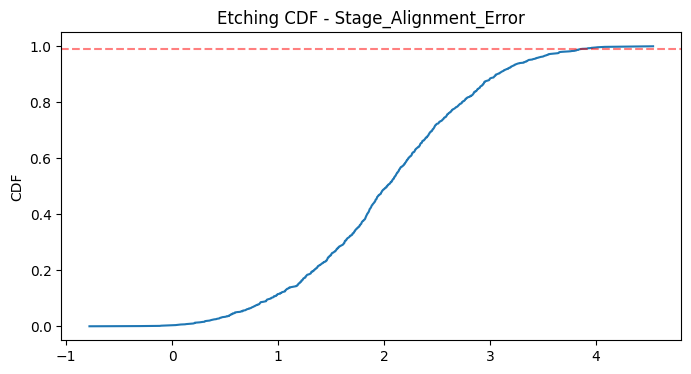

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# =========================================
# 7) 공정별 추가 시각화 (Violin Plot 적용 버전)
# =========================================

def plot_violin_by_defect(df_t, tool_name, target_col="Defect", max_cols=6):
    """박스플롯 대신 분포까지 보여주는 바이올린 플롯 사용"""
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c]) and c != target_col]
    cols = num_cols[:max_cols]
    if not cols:
        print(f"{tool_name}: numeric columns 없음")
        return

    # 서브플롯 설정 (한 화면에 여러 개 배치)
    ncols = 3
    nrows = int(np.ceil(len(cols) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    fig.suptitle(f"[{tool_name}] Feature Distribution by {target_col}", fontsize=16)
    axes = axes.flatten()

    for i, c in enumerate(cols):
        # sns.violinplot 사용
        sns.violinplot(x=target_col, y=c, data=df_t, ax=axes[i], inner="quartile", palette="muted")
        axes[i].set_title(f"{c}")
        axes[i].set_xlabel("Target (0:Normal, 1:Defect)")
        axes[i].set_ylabel("Value")

    # 남는 칸 제거
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 나머지 함수들은 동일하게 유지하되, 호출부만 업데이트 ---

def plot_kde_overlap(df_t, tool_name, target_col="Defect", max_cols=4):
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c]) and c != target_col]
    cols = num_cols[:max_cols]
    if not cols: return
    for c in cols:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(data=df_t, x=c, hue=target_col, fill=True, common_norm=False, palette="Set1")
        plt.title(f"{tool_name} KDE - {c}")
        plt.show()


def plot_scatter_top_pairs(df_t, tool_name, topk=3):
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c])]
    if len(num_cols) < 2: return
    c = df_t[num_cols].corr().abs()
    pairs = []
    for i in range(len(num_cols)):
        for j in range(i+1, len(num_cols)):
            a, b = num_cols[i], num_cols[j]
            val = c.loc[a, b]
            if pd.isna(val): continue
            pairs.append((a, b, float(val)))
    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:topk]
    for a, b, v in pairs:
        plt.figure(figsize=(6, 5))
        sns.scatterplot(data=df_t, x=a, y=b, hue=target_col, alpha=0.5)
        plt.title(f"{tool_name}: {a} vs {b} (|corr|={v:.2f})")
        plt.show()

def plot_cdf_tail(df_t, tool_name, col):
    if col not in df_t.columns or not pd.api.types.is_numeric_dtype(df_t[col]): return
    s = df_t[col].dropna().sort_values()
    y = np.arange(1, len(s)+1) / len(s)
    plt.figure(figsize=(8, 4))
    plt.plot(s, y)
    plt.axhline(0.99, color='red', linestyle='--', alpha=0.5) # 99% 라인 추가
    plt.title(f"{tool_name} CDF - {col}")
    plt.ylabel("CDF")
    plt.show()

# =========================================
# 실행부 (루프)
# =========================================
for tool_name, df_t in tool_raw.items():
    print(f"\n{'='*30}\n[RUNNING ANALYSIS] Tool: {tool_name}\n{'='*30}")
    
    # 1. 바이올린 플롯 호출 (Boxplot 대체)
    plot_violin_by_defect(df_t, tool_name, target_col=target_col, max_cols=6)

    # 2. KDE 오버랩 (Seaborn으로 더 깔끔하게 출력)
    plot_kde_overlap(df_t, tool_name, target_col=target_col, max_cols=4)
    
    # 4. 산점도 (Hue 추가하여 불량 분포 시각화)
    plot_scatter_top_pairs(df_t, tool_name, topk=3)

    # 5. CDF tail 분석
    for col in ["Particle_Count", "Vibration_Level", "Stage_Alignment_Error"]:
        if col in df_t.columns:
            plot_cdf_tail(df_t, tool_name, col)

In [9]:
# =========================================
# 7.5) 시각화 유틸 (Defect 기준)
# =========================================
COL_DEFECT = "Defect"
COL_ALIGN  = "Stage_Alignment_Error"
COL_VIB    = "Vibration_Level"
COL_RF     = "RF_Power"
COL_PRES   = "Vacuum_Pressure"


def _prep(df, cols):
    d = df[cols].copy()
    d = d.dropna()
    d[COL_DEFECT] = d[COL_DEFECT].astype(int)
    return d


def plot_defect_rate_by_bin(df_in, x_col, q=10, title=None):
    d = _prep(df_in, [x_col, COL_DEFECT])
    d["bin"] = pd.qcut(d[x_col], q=q, duplicates="drop")
    rate = d.groupby("bin")[COL_DEFECT].mean()

    plt.figure(figsize=(7, 4))
    rate.plot(marker="o")
    plt.ylabel("Defect Rate")
    plt.xlabel(f"{x_col} (quantile bins)")
    plt.title(title or f"Defect Rate by {x_col} bins")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_2d_defect_heatmap(df_in, x_col, y_col, bins=12, title=None):
    d = _prep(df_in, [x_col, y_col, COL_DEFECT])

    x_bins = pd.cut(d[x_col], bins=bins)
    y_bins = pd.cut(d[y_col], bins=bins)

    hm = d.groupby([x_bins, y_bins])[COL_DEFECT].mean().unstack()

    plt.figure(figsize=(7, 6))
    sns.heatmap(hm, cmap="Reds", cbar_kws={"label": "Defect Probability"})
    plt.title(title or f"Defect Probability Heatmap: {x_col} vs {y_col}")
    plt.xlabel(y_col + " bins")
    plt.ylabel(x_col + " bins")
    plt.tight_layout()
    plt.show()


def plot_box_by_defect(df_in, x_col, title=None):
    d = _prep(df_in, [x_col, COL_DEFECT])

    plt.figure(figsize=(4.5, 4))
    sns.boxplot(data=d, x=COL_DEFECT, y=x_col)
    plt.title(title or f"{x_col} by Defect")
    plt.tight_layout()
    plt.show()



=== Lithography Visualization Pipeline ===


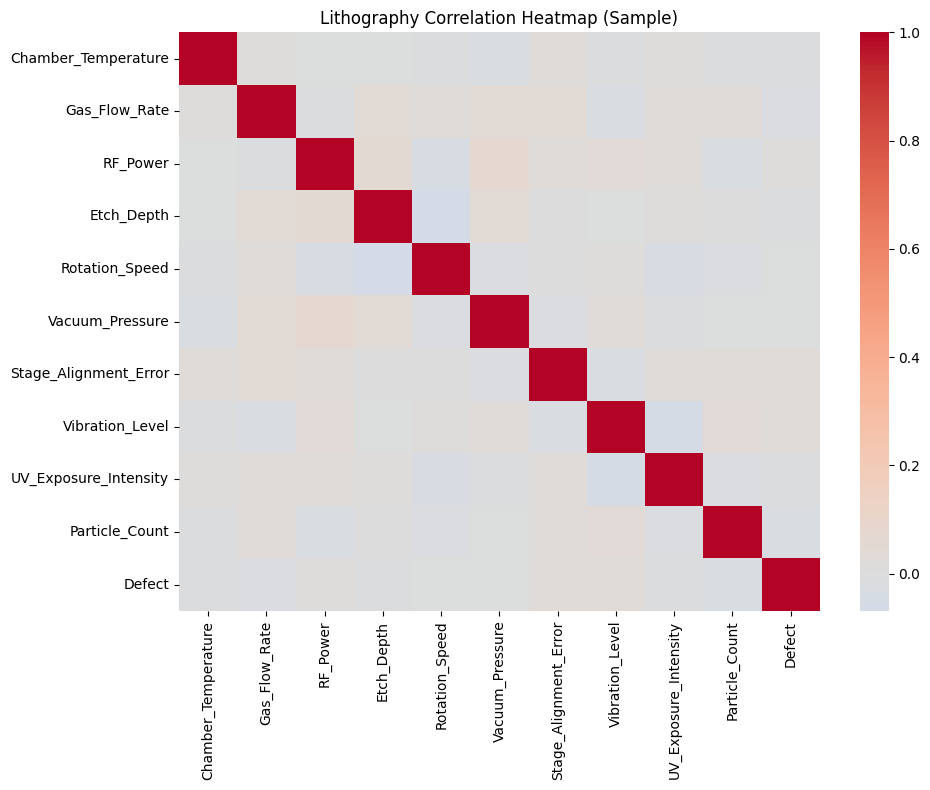

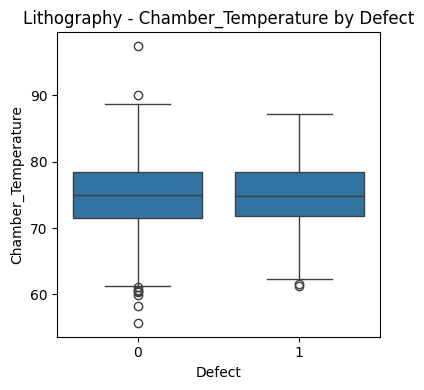

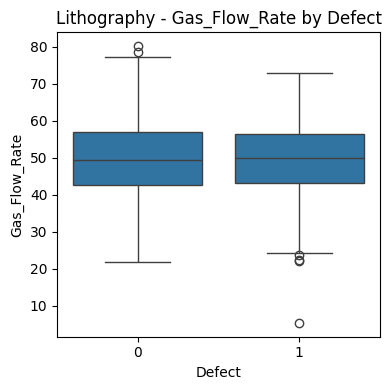

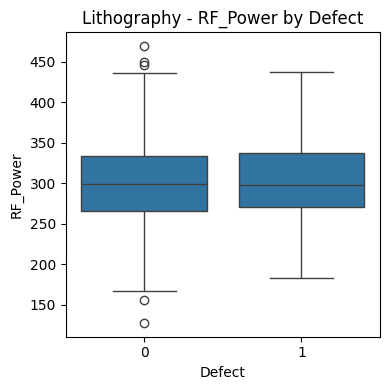

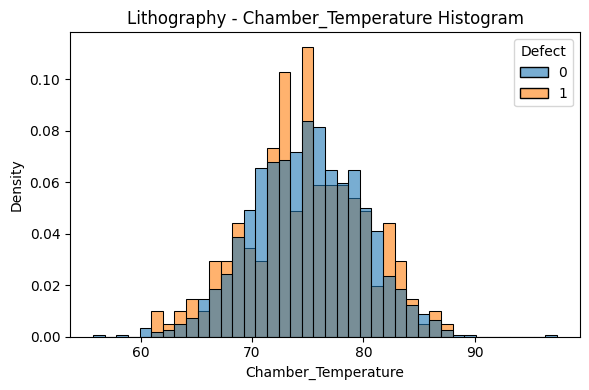

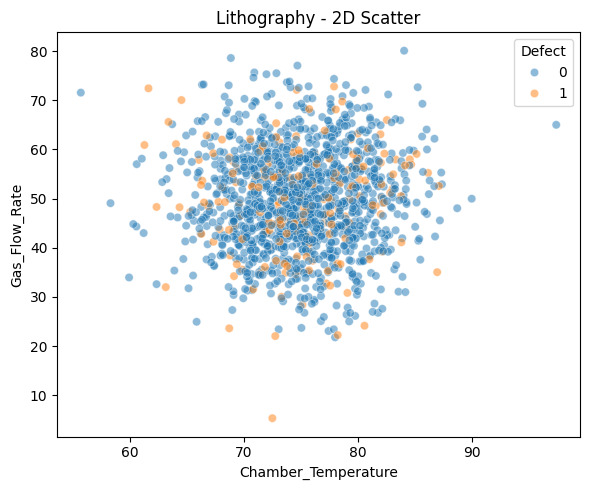

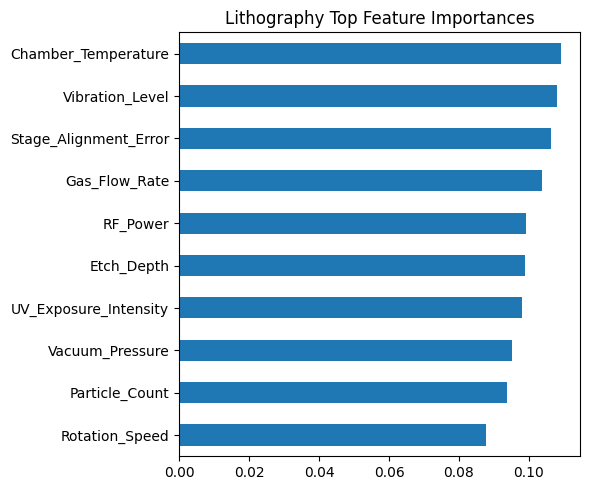

Lithography Top important features:


Chamber_Temperature      0.109137
Vibration_Level          0.108026
Stage_Alignment_Error    0.106231
Gas_Flow_Rate            0.103692
RF_Power                 0.099096
Etch_Depth               0.098989
UV_Exposure_Intensity    0.098132
Vacuum_Pressure          0.095185
Particle_Count           0.093791
Rotation_Speed           0.087721
dtype: float64

=== Deposition Visualization Pipeline ===


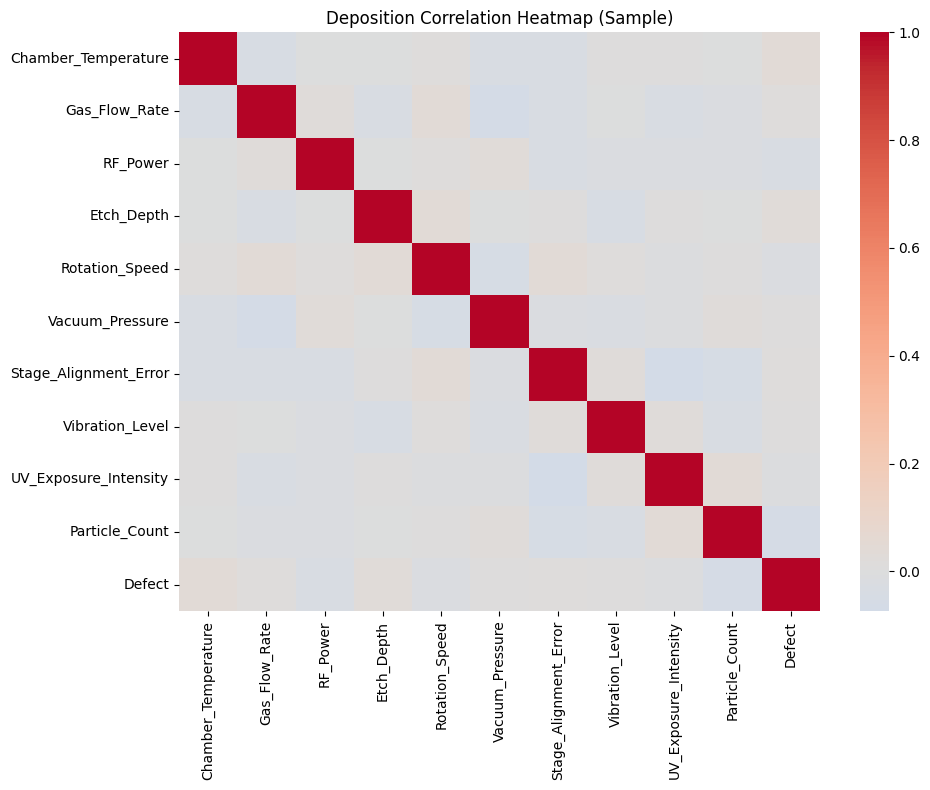

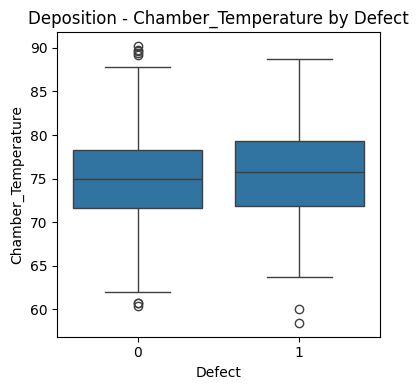

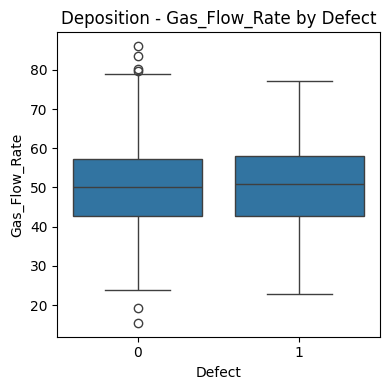

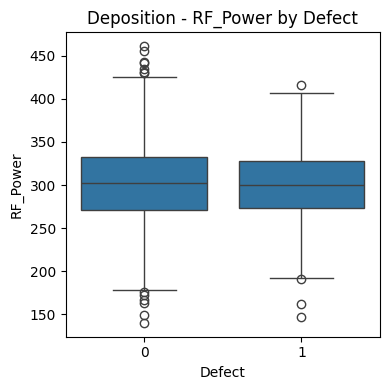

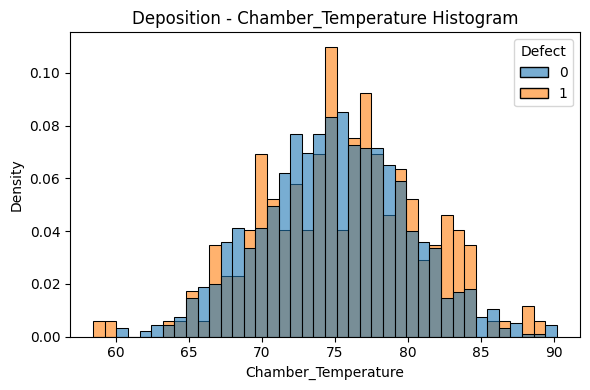

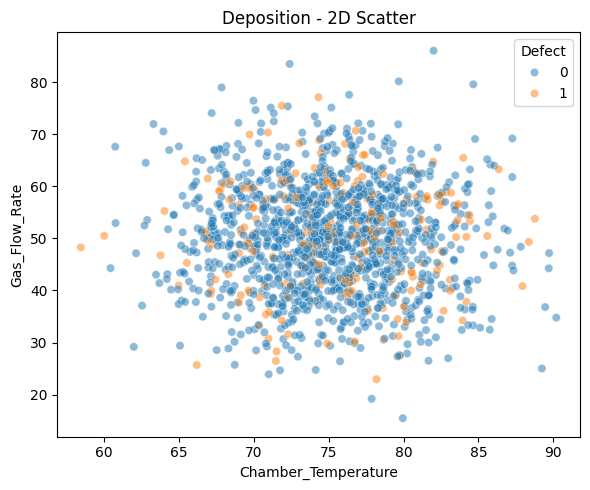

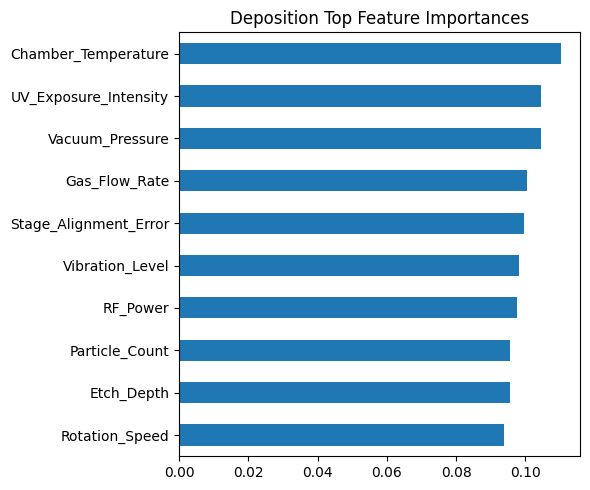

Deposition Top important features:


Chamber_Temperature      0.110285
UV_Exposure_Intensity    0.104622
Vacuum_Pressure          0.104517
Gas_Flow_Rate            0.100465
Stage_Alignment_Error    0.099544
Vibration_Level          0.098289
RF_Power                 0.097508
Particle_Count           0.095545
Etch_Depth               0.095490
Rotation_Speed           0.093735
dtype: float64

=== Etching Visualization Pipeline ===


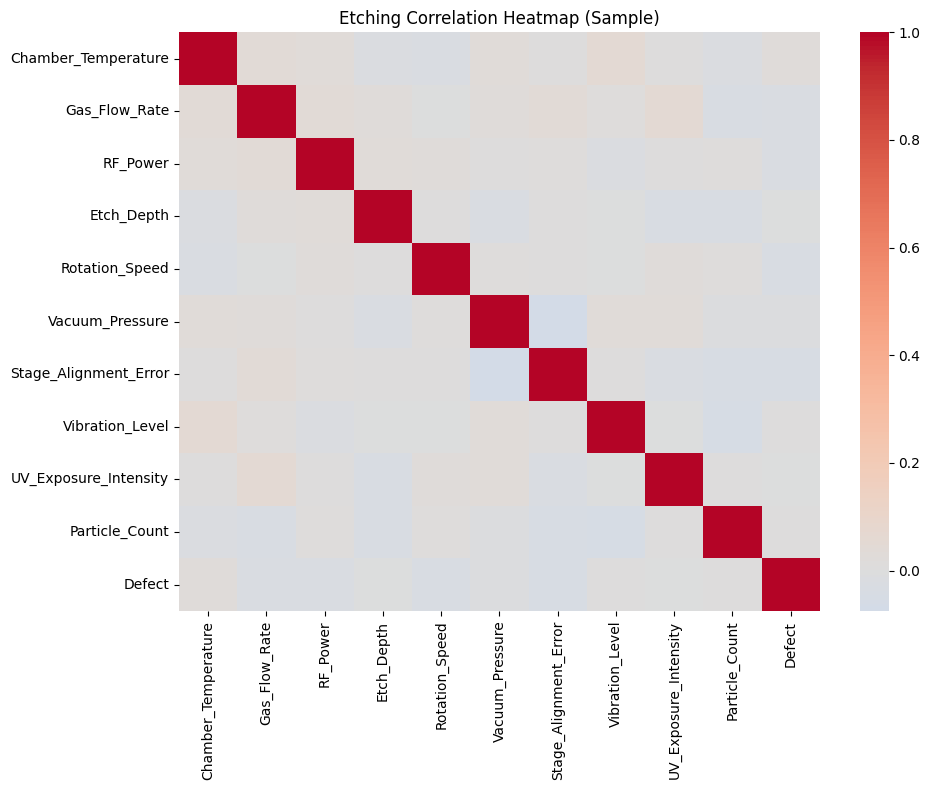

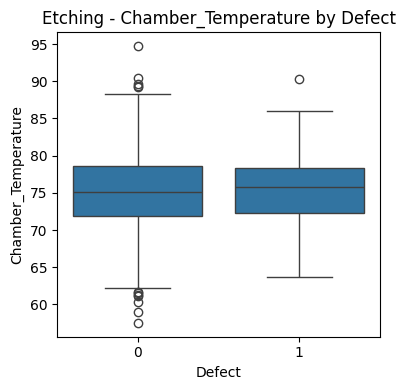

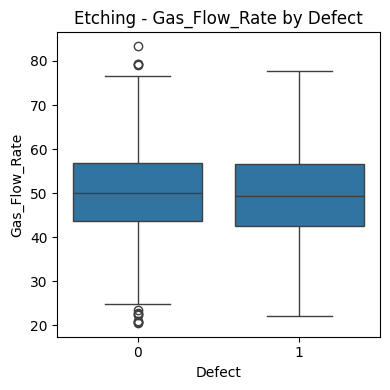

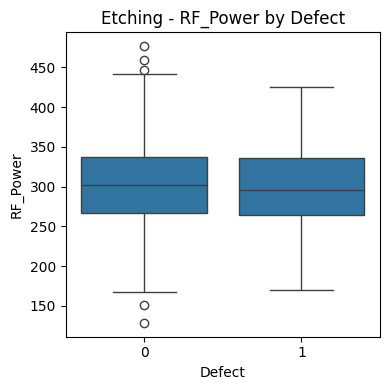

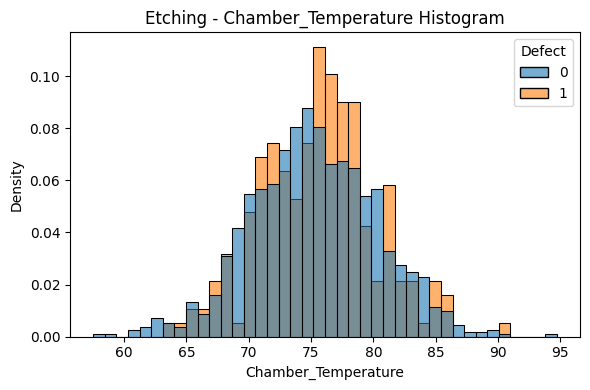

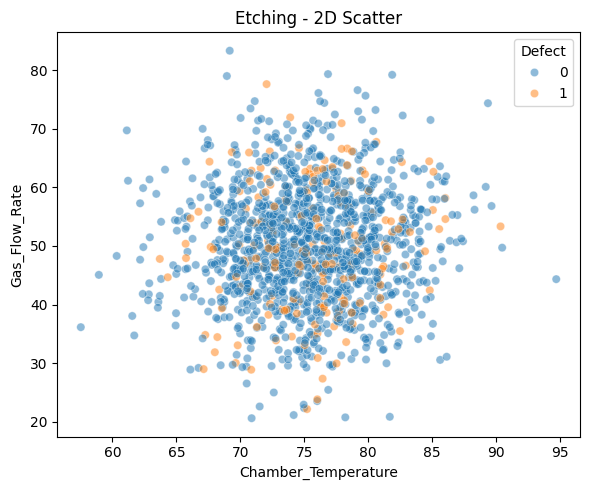

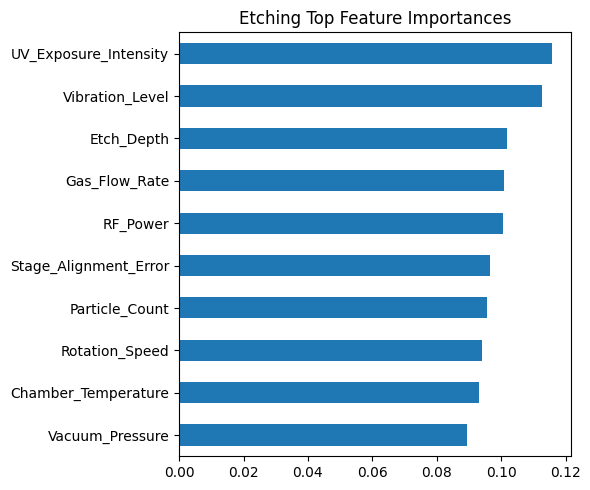

Etching Top important features:


UV_Exposure_Intensity    0.115808
Vibration_Level          0.112594
Etch_Depth               0.101907
Gas_Flow_Rate            0.100844
RF_Power                 0.100435
Stage_Alignment_Error    0.096623
Particle_Count           0.095471
Rotation_Speed           0.094016
Chamber_Temperature      0.092971
Vacuum_Pressure          0.089331
dtype: float64

In [10]:
# =========================================
# 8) 공정별 시각화 파이프라인 (관계성 설명용)
# =========================================

def run_viz_pipeline(df_t, tool_name, target_col="Defect", max_cols=15, top_k=10):
    # 숫자형 컬럼만 사용
    num_cols = [c for c in df_t.columns if pd.api.types.is_numeric_dtype(df_t[c]) and c != target_col]
    if not num_cols:
        print(f"{tool_name}: numeric columns 없음")
        return

    # 1) Correlation heatmap (일부 샘플)
    sample_cols = num_cols[:max_cols] + [target_col]
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_t[sample_cols].corr(), cmap="coolwarm", center=0)
    plt.title(f"{tool_name} Correlation Heatmap (Sample)")
    plt.tight_layout()
    plt.show()

    # 2) Defect 기준 분포 비교 (Boxplot)
    box_cols = num_cols[:3]
    for col in box_cols:
        plt.figure(figsize=(4, 4))
        sns.boxplot(x=target_col, y=col, data=df_t)
        plt.title(f"{tool_name} - {col} by Defect")
        plt.tight_layout()
        plt.show()

    # 3) Threshold / Histogram 비교
    hist_col = box_cols[0]
    plt.figure(figsize=(6, 4))
    sns.histplot(
        data=df_t,
        x=hist_col,
        hue=target_col,
        bins=40,
        stat="density",
        common_norm=False,
        alpha=0.6
    )
    plt.title(f"{tool_name} - {hist_col} Histogram")
    plt.tight_layout()
    plt.show()

    # 4) 2D 조합 효과 (Scatter)
    if len(box_cols) >= 2:
        plt.figure(figsize=(6, 5))
        sns.scatterplot(
            data=df_t,
            x=box_cols[0],
            y=box_cols[1],
            hue=target_col,
            alpha=0.5
        )
        plt.title(f"{tool_name} - 2D Scatter")
        plt.tight_layout()
        plt.show()

    # 5) RandomForest 기반 Feature Importance
    X = df_t[num_cols]
    y = df_t[target_col].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            random_state=42,
            n_jobs=-1
        ))
    ])

    pipe.fit(X_train, y_train)

    rf = pipe.named_steps["model"]
    importances = pd.Series(rf.feature_importances_, index=X.columns)

    plt.figure(figsize=(6, 5))
    importances.sort_values(ascending=False).head(top_k).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.title(f"{tool_name} Top Feature Importances")
    plt.tight_layout()
    plt.show()

    print(f"{tool_name} Top important features:")
    display(importances.sort_values(ascending=False).head(top_k))


for tool_name, df_t in tool_raw.items():
    print(f"=== {tool_name} Visualization Pipeline ===")

    run_viz_pipeline(df_t, tool_name, target_col=target_col)




=== Lithography ===


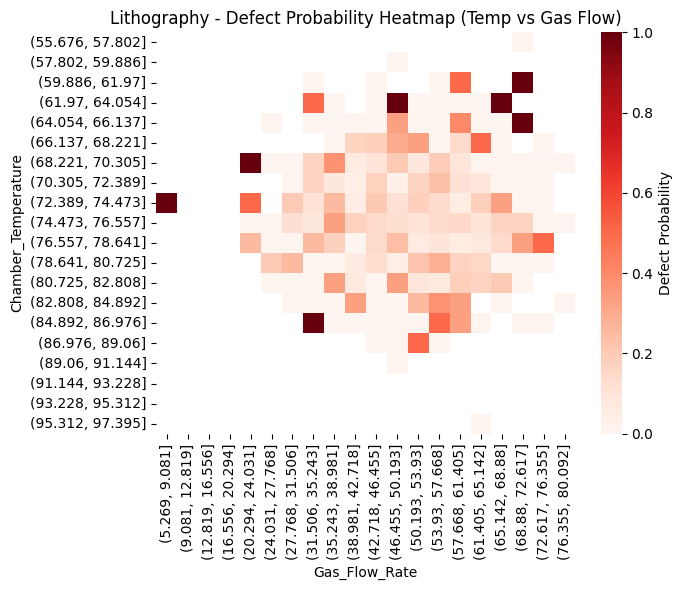

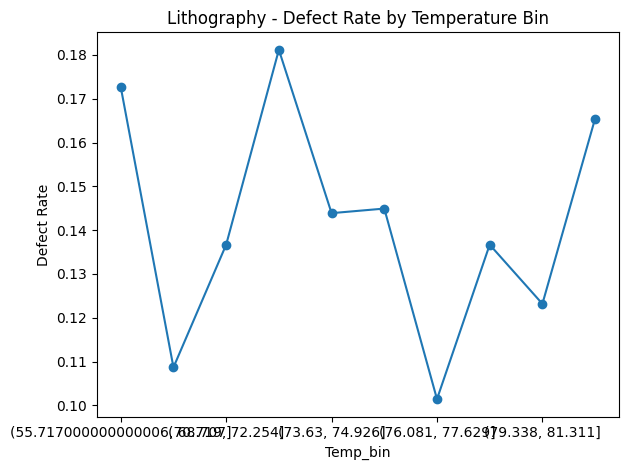


=== Deposition ===


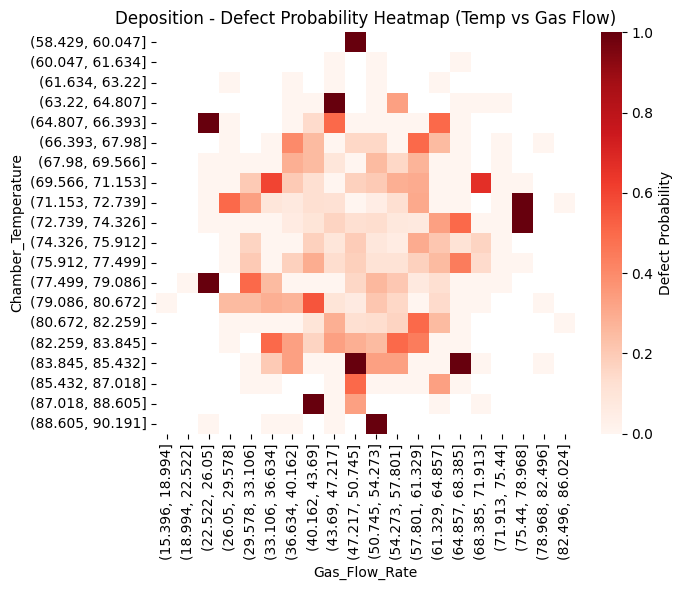

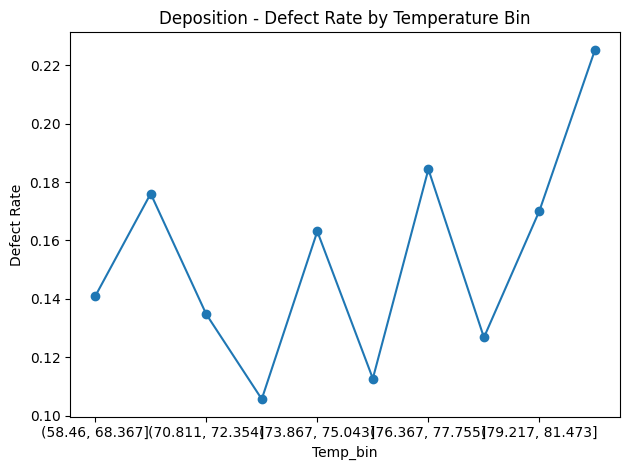


=== Etching ===


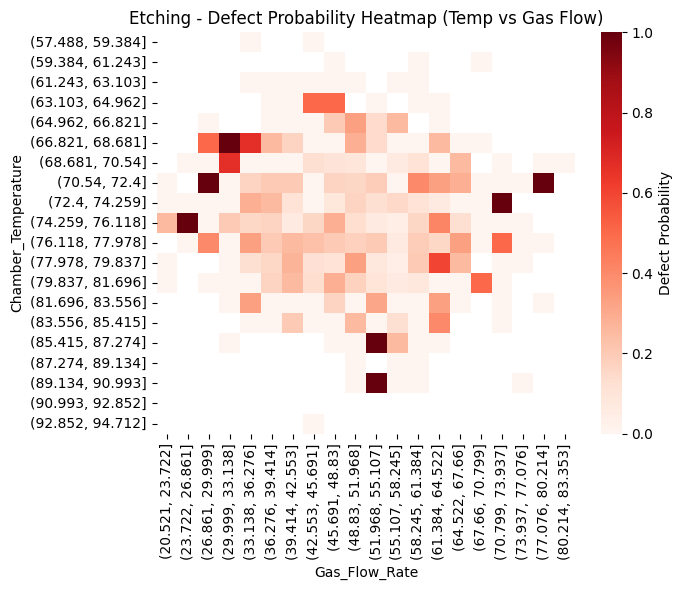

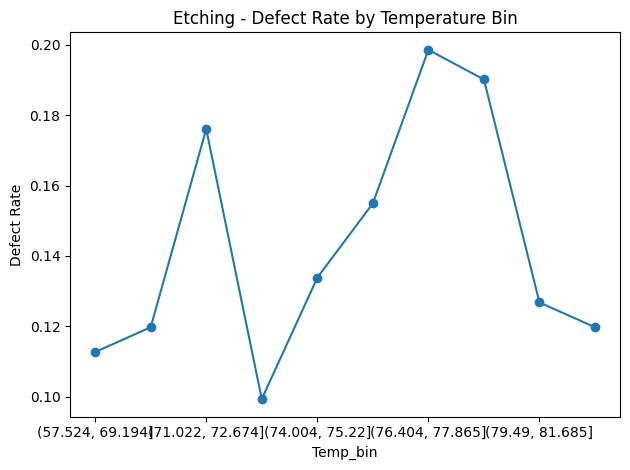

In [11]:
for tool_name, df in tool_raw.items():
    print(f"\n=== {tool_name} ===")

    # 1) Heatmap (Temp vs Gas Flow)
    temp_bins = pd.cut(df["Chamber_Temperature"], bins=20)
    flow_bins = pd.cut(df["Gas_Flow_Rate"], bins=20)
    heatmap_data = df.groupby([temp_bins, flow_bins])["Defect"].mean().unstack()

    plt.figure(figsize=(7,6))
    sns.heatmap(
        heatmap_data,
        cmap="Reds",
        cbar_kws={"label": "Defect Probability"}
    )
    plt.title(f"{tool_name} - Defect Probability Heatmap (Temp vs Gas Flow)")
    plt.tight_layout()
    plt.show()

    # 2) Defect Rate by Temperature Bin (qcut)
    df = df.copy()
    df["Temp_bin"] = pd.qcut(df["Chamber_Temperature"], q=10, duplicates="drop")

    rate = df.groupby("Temp_bin")["Defect"].mean()

    rate.plot(marker="o")
    plt.ylabel("Defect Rate")
    plt.title(f"{tool_name} - Defect Rate by Temperature Bin")
    plt.tight_layout()
    plt.show()



=== Etching ===


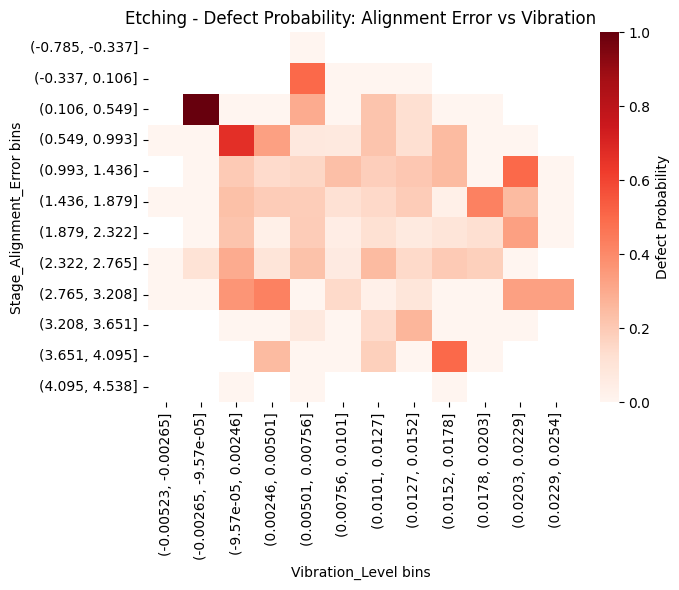

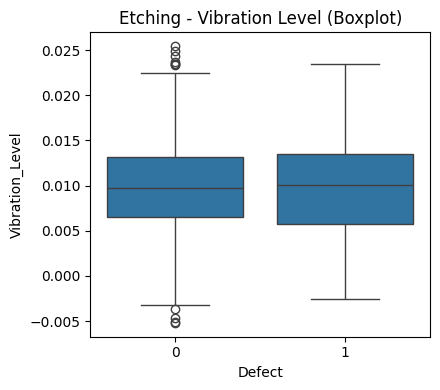

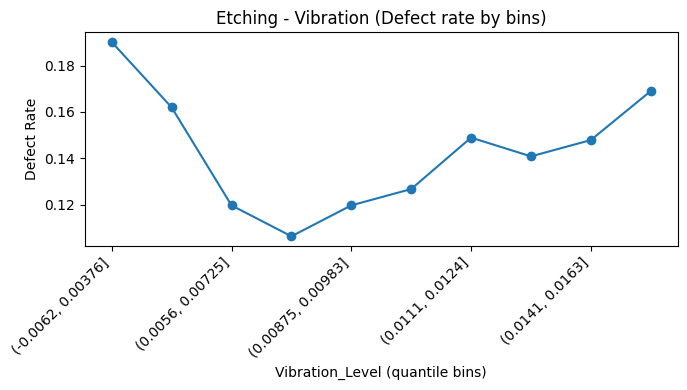


=== Deposition ===


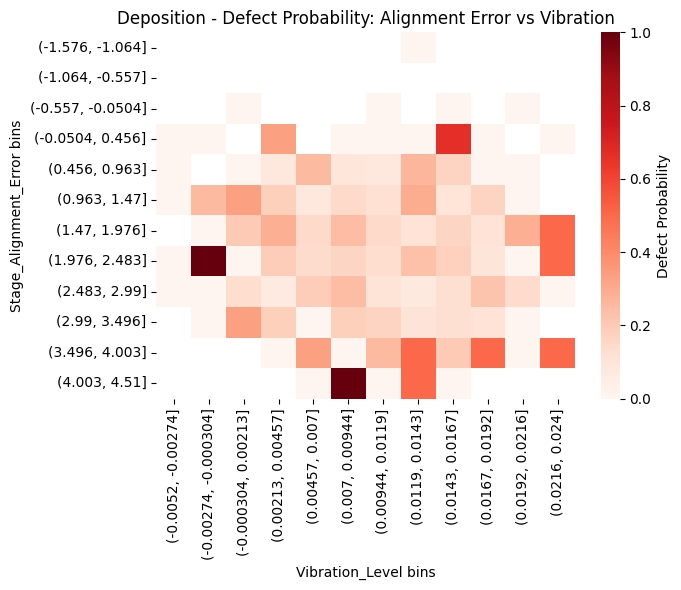

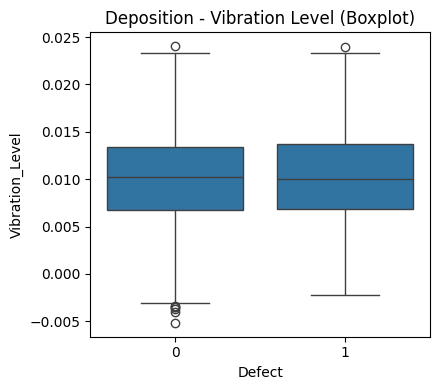

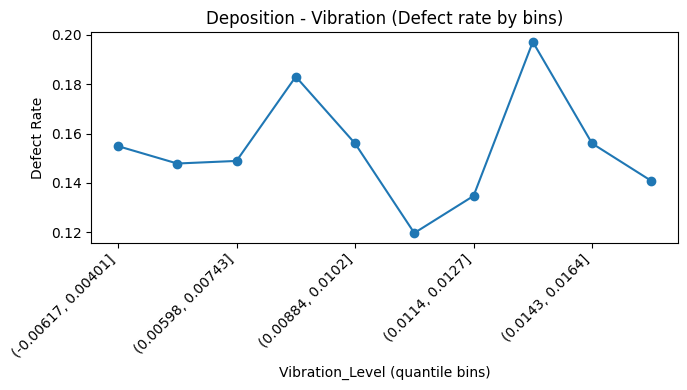


=== Lithography ===


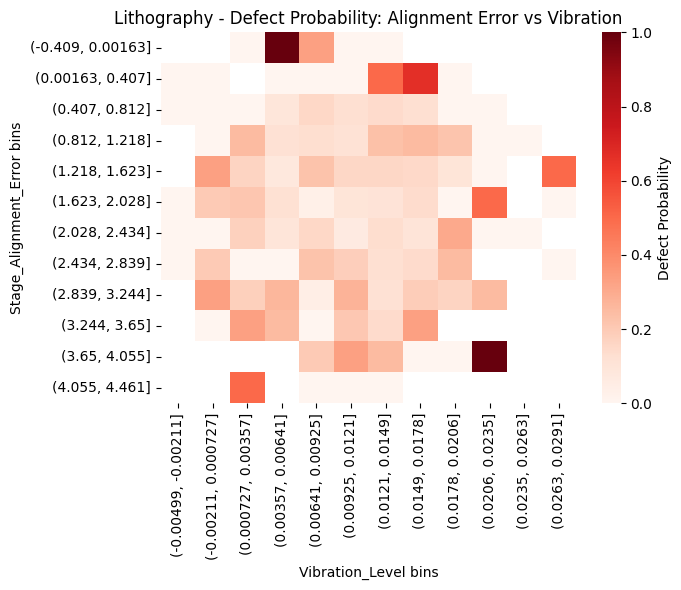

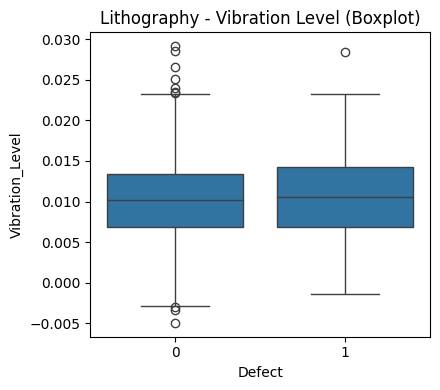

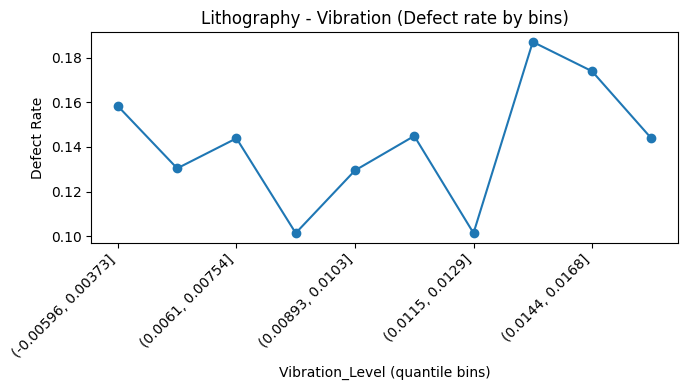

In [12]:
# Alignment_Error vs Vibration_Level

for tool_name in ["Etching", "Deposition", "Lithography"]:
    df = tool_raw[tool_name]
    print(f"\n=== {tool_name} ===")

    # (1) 2D 확률 히트맵
    plot_2d_defect_heatmap(
        df,
        x_col=COL_ALIGN,
        y_col=COL_VIB,
        bins=12,
        title=f"{tool_name} - Defect Probability: Alignment Error vs Vibration"
    )

    # (2) 참고: 진동 단독도 같이 확인
    plot_box_by_defect(df, COL_VIB, title=f"{tool_name} - Vibration Level (Boxplot)")
    plot_defect_rate_by_bin(df, COL_VIB, q=10, title=f"{tool_name} - Vibration (Defect rate by bins)")



=== Etching ===


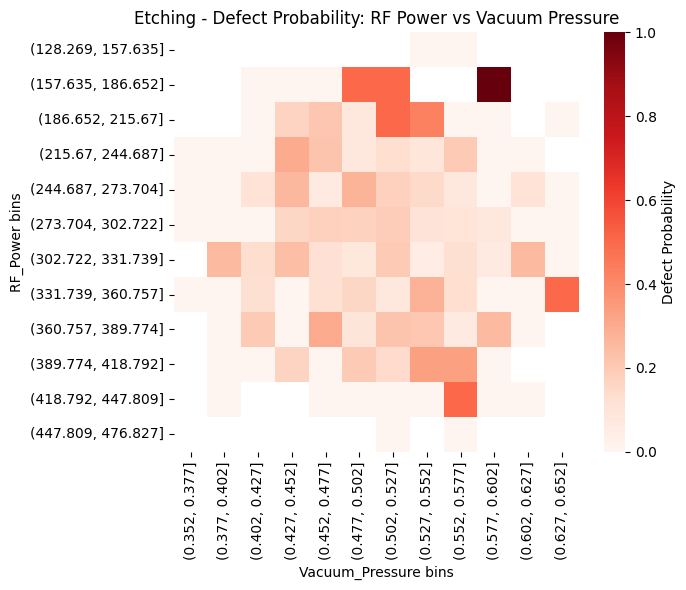

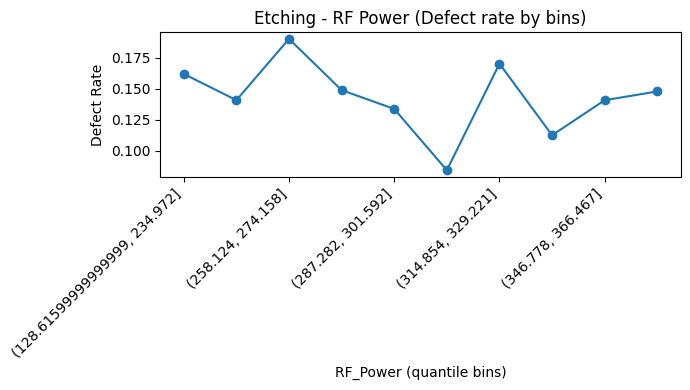

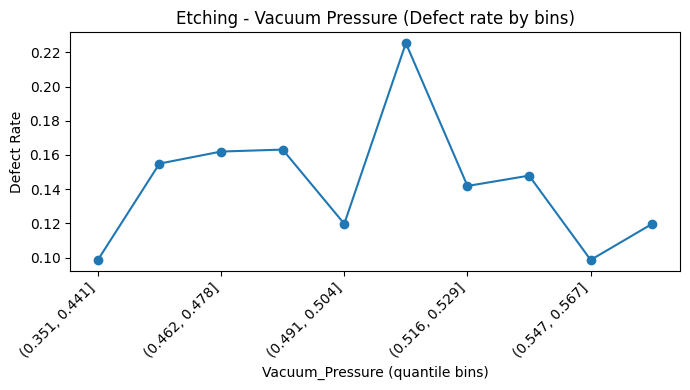


=== Deposition ===


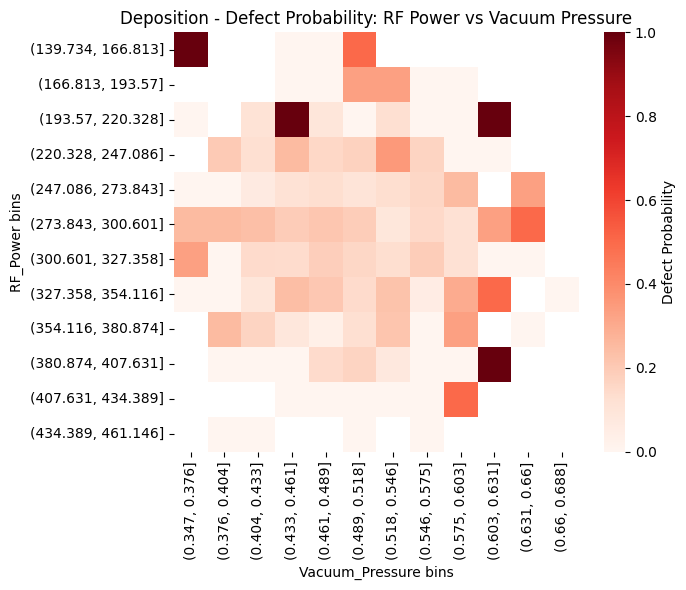

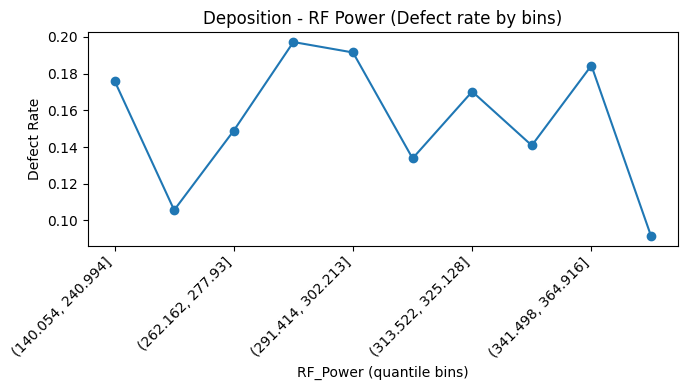

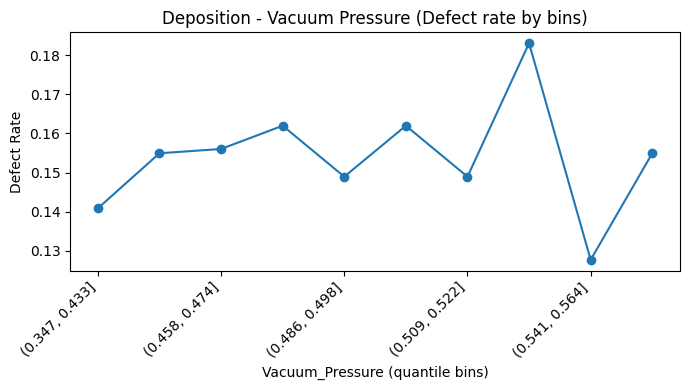


=== Lithography ===


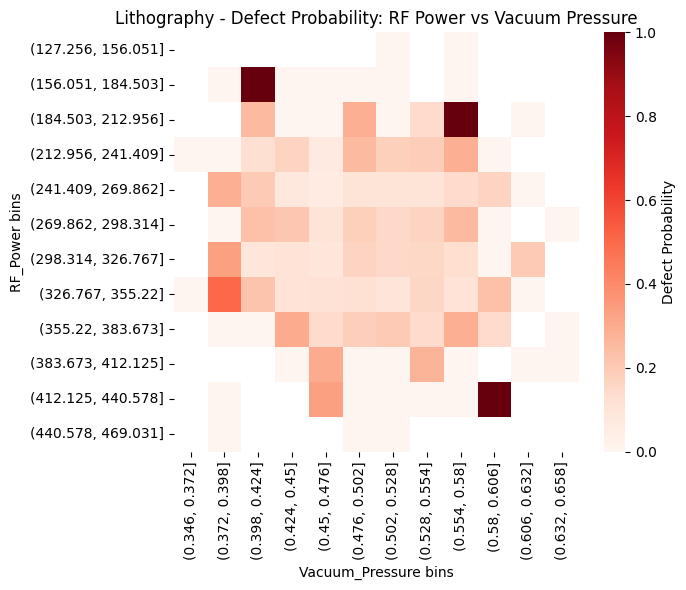

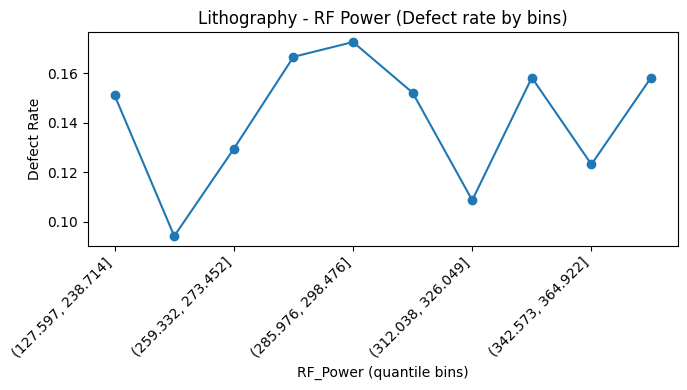

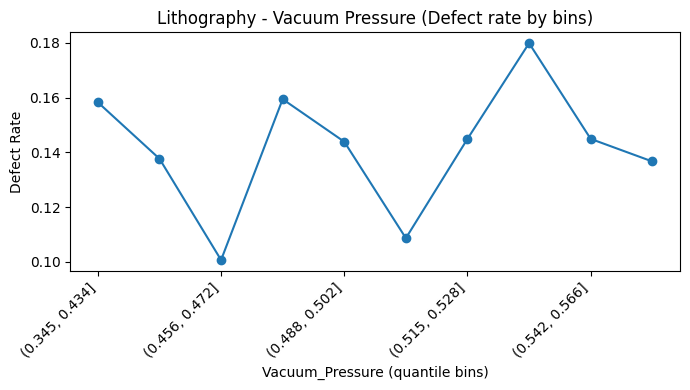

In [13]:
#  RF power vs Vacuum Pressure

for tool_name in ["Etching", "Deposition", "Lithography"]:
    df = tool_raw[tool_name]
    print(f"\n=== {tool_name} ===")

    # (1) 2D 확률 히트맵
    plot_2d_defect_heatmap(
        df,
        x_col=COL_RF,
        y_col=COL_PRES,
        bins=12,
        title=f"{tool_name} - Defect Probability: RF Power vs Vacuum Pressure"
    )

    # (2) 단독 bin plot도 같이 (옵션)
    plot_defect_rate_by_bin(df, COL_RF, q=10, title=f"{tool_name} - RF Power (Defect rate by bins)")
    plot_defect_rate_by_bin(df, COL_PRES, q=10, title=f"{tool_name} - Vacuum Pressure (Defect rate by bins)")
